In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from fig_config import figure_features
import os
import pandas as pd
import matplotlib


import pycbc.types 

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [ ]:
root_dir = '/home/alberto_sinigaglia/gaia'
mass_range = 'CNN_low_mass'

In [ ]:
def get_path(root_dir, file_name, mass_range, train=True, signal=True):

        """
        Loads the data for a given path, yielding a type pycbc.timeseries.TimeSeries
        ----------------------------------------------------------------------------

        Arguments:
        root_dir -- root directory where data is stored
        file_name -- name of the file with extention
        mass_range -- to complete path, must contain 'CNN_low_mass', 'CNN_mid_mass_I', 'CNN_mid_mass_II' or 'CNN_high_mass'
        train -- boolean, True for training set, False for test set
        signal -- boolean, True for signal, False for noise

        Return:
        path -- path to the file
        """

        base_dir = os.path.join(root_dir, mass_range)

        if train:
            path = os.path.join(base_dir, 'Training')
            if signal:
                path = os.path.join(path, 'Signal')
            else:
                path = os.path.join(path, 'Noise')
        else:
            path = os.path.join(base_dir, 'Test')
            if signal:
                path = os.path.join(path, 'Signal')
            else:
                path = os.path.join(path, 'Noise')

        full_path = path + '/' + file_name

        return full_path

Let's load and preprocess the data for the CNN

In [2]:
class GW_data_generator():

    # This class will generate an array of temporal series, each row of the array being a GW series, and also will generate its corresponding
    # label (0 for noise, 1 for signal), (and its chirp mass and mass ratio).
    # ----------------------------------------------------------------------------------------------------------------------------------------
    
    def __init__(self, record):
        self.record = record


    def shuffle_data(self):
        """
        This function will generate a list of numbers shuffled to identify the series
        """
        shuffled_idx = np.random.permutation(len(self.record)) # we shuffle the training samples

        return shuffled_idx

    def load_data(self, root_dir, file_name, mass_range, train=True, signal=True):
        """
        Loads the data for a given path, yielding a type pycbc.timeseries.TimeSeries
        ----------------------------------------------------------------------------

        Arguments:
        root_dir -- root directory where data is stored
        file_name -- name of the file with extention
        mass_range -- to complete path, must contain 'CNN_low_mass', 'CNN_mid_mass_I', 'CNN_mid_mass_II' or 'CNN_high_mass'
        train -- boolean, True for training set, False for test set
        signal -- boolean, True for signal, False for noise

        Return:
        data -- type pycbc.timeseries.TimeSeries
        """

        path = self.get_path(root_dir, file_name, mass_range, train, signal)
        data = pycbc.types.timeseries.load_timeseries(path + '/' + file_name)

        return data


    def process_data(self, data):
        '''
        This function will process the data, whitening, bandpassing and normalising it.
        '''

        length = len(data)
        segment_duration = data.get_duration()
        sample_rate = data.get_sample_rate()
        max_filter_duration = segment_duration / 4
        frec_low_cutoff = 30
        frec_high_cutoff = 200

        # whiten the data
        data = data.whiten(segment_duration, max_filter_duration, remove_corrupted=True, low_frequency_cutoff=frec_low_cutoff, return_psd=False)

        # bandpass
        data = data.lowpass_fir(frec_high_cutoff, 8, beta=5.0, remove_corrupted=True) # bandpassing: supress data for frec>300
        data = data.highpass_fir(frec_low_cutoff, 8, beta=5.0, remove_corrupted=True) # bandpassing: supress data for frec<30

        # normalising data to 1
        data = data / max(data)

        # append zeros to beginning and end of the data to keep the input shape unchanged after cropping corrupted segments
        length_cr = len(data)
        dif = length-length_cr
        data.prepend_zeros(int(dif / 2)) # append zeros at beginning
        data.append_zeros(int(dif / 2)) # append zeros at end

        # return an array
        data = np.squeeze(np.array(data))

        return data

    def generate_batch(self, shuffled_idx, purpose, processing):
        '''
        This function will generate a batch of series, each batch containing the same number of noise and signal series.

        Arguments:
        series_idx -- series identification number iloc: if 1050 images, then it takes num in [0,1050]
        purpose -- neccesary to specify directory path
        batch_size -- len of the batch to be considered
        processing -- True if we want to process the data, False if we want the raw data

        Returns:
        series -- array containing the temporal series
        labels -- array with corresponding 0 for noise and 1 for signal
        (chirp mass -- array containing corresponding chirp mass of signal series)
        (mass ratio -- array containing corresponding mass ratio of signal series)
        '''

        # arrays to store our batched data
        series, labels = np.empty((1,int(3*2048)),dtype=float), np.array([])
        #chirpM, qratio = [], []
        
        for idx in shuffled_idx:

            ######   WE APPEND A SIGNAL SERIES  ########
            aux_purpose = 'signal'
            parameters = self.record.iloc[idx] # returns the row of data corresponding to such series iloc
            file_name = parameters['Ref.Name']   

            data = self.load_data(root_dir, file_name, mass_range, train=(purpose=='train'), signal=(aux_purpose=='signal')) 

            # here we load the data and process it according to signal or noise
            if processing == True:    
                series_np = self.process_data(file_name, [purpose, aux_purpose])
            if processing == False:
                series_np = np.array(load_data(file_name, [purpose, aux_purpose]))

            labels = np.hstack((labels, 1))
            series = np.vstack((series, series_np))
            """
            chirp = parameters['Chirp mass']
            qM = parameters['Mass ratio']

            chirpM.append(chirp)
            qratio.append(qM)
            """

            #######  WE APPEND A NOISE SERIES  ##########
            aux_purpose = 'noise'

            if purpose == 'train':
                aux_path = training_noise_dir
            elif purpose == 'test':
                aux_path = test_noise_dir

            file_name = 'noise_sample{}.hdf'.format(idx+1) # csv indexes gows from 0 to ..., but noise samples goes from 1 to ...

            if processing == True:    
                series_np = self.process_data(file_name, [purpose, aux_purpose])
            if processing == False:
                series_np = np.array(load_data(file_name, [purpose, aux_purpose]))
                
            result = np.hstack((result, 0))
            series = np.vstack((series, series_np))
            
        series = np.delete(series, 0, axis=0) # delete first row of np.empty
        return series, result

In [3]:
def append_ext_hdf(fn):
    return fn+".hdf"

# for SERIES
record_path_train = os.path.join(training_dir,'Records_training_signal.csv') # will open the csv file with the info 
record_train_series = pd.read_csv(record_path_train, sep='\t')

record_path_test = os.path.join(test_dir,'Records_test_signal.csv')
record_test_series = pd.read_csv(record_path_test, sep='\t')

record_test_series["Ref.Name"]=record_test_series["Ref.Name"].apply(append_ext_hdf)


# test set of series 
data_generator_test = GW_data_generator(record_test_series)
test_idx = data_generator_test.generate_indexes()
test_X_series, _ = data_generator_test.generate_series(test_idx, purpose='test', processing=True)

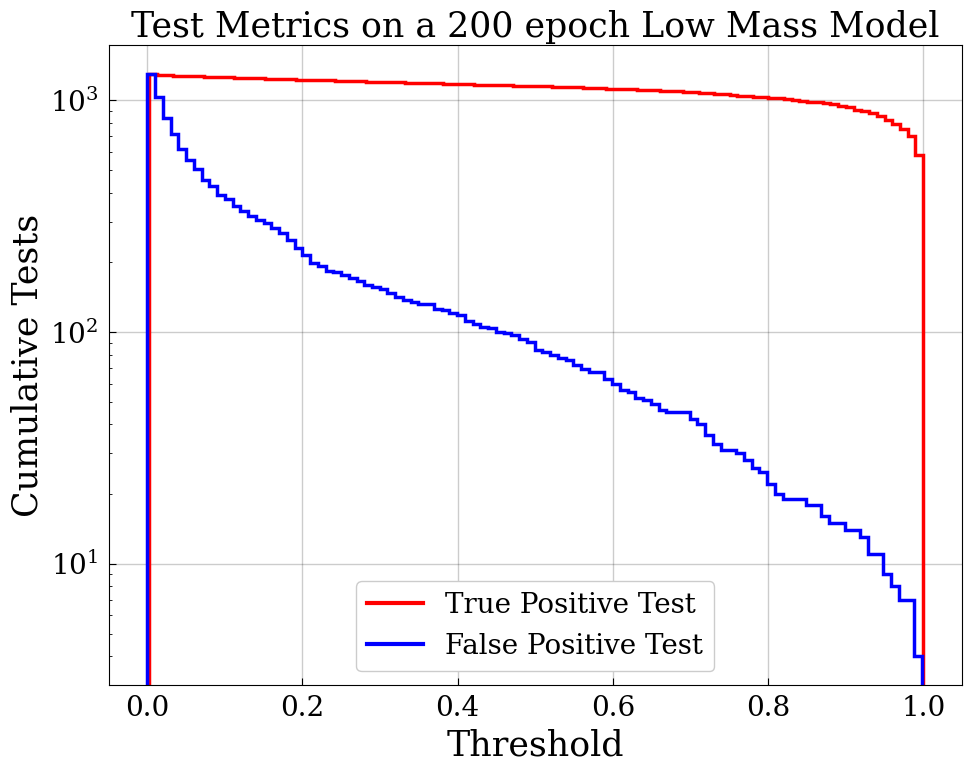

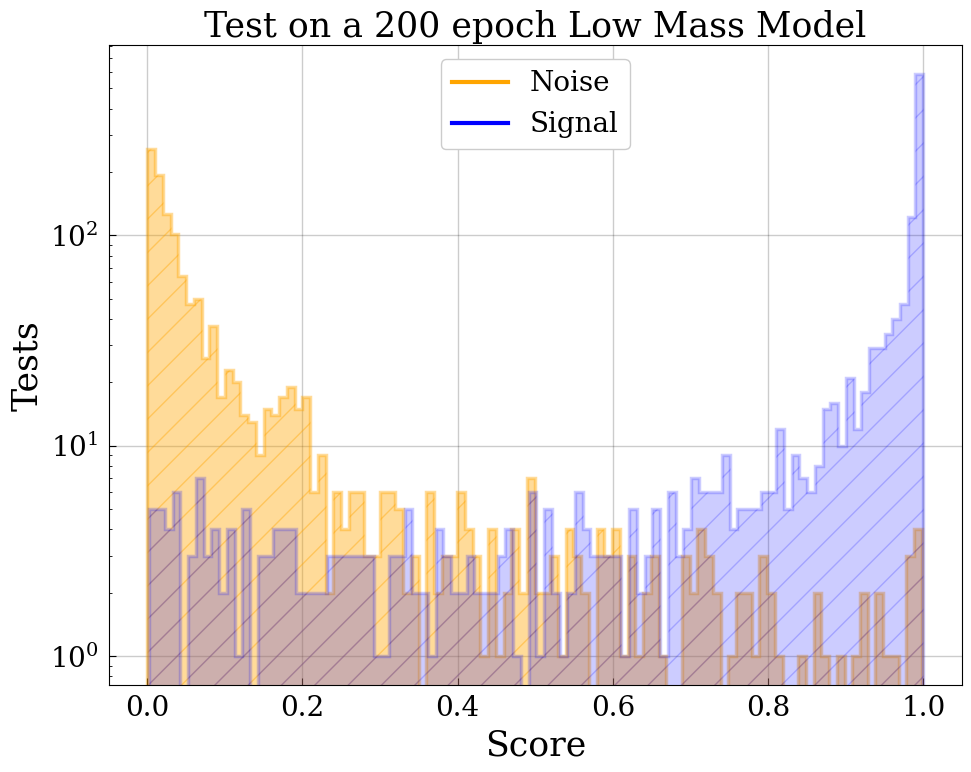

In [5]:
dirs = '/data/danibelt/CNN/Classifier/Low_mass/Run 10 - 3 ResNet, Last mod/Classifier_epochs200'


model = tf.keras.models.load_model(dirs)

test_Y_pred = model.predict(test_X_series)

# por la forma de haber construido la base de datos, las series impares corresponden a ruido

# True Positive Test -- plot noise series

figure_features()
fig = plt.figure(figsize=(10,8))
plt.hist(test_Y_pred[0::2],bins=100,histtype='step',color='red', cumulative=-1, linewidth=2.5, label= "True Positive Test")
plt.hist(test_Y_pred[1::2],bins=100,histtype='step',color='blue', cumulative=-1, linewidth=2.5, label= "False Positive Test")
plt.ylabel('Cumulative Tests', fontsize=25)
plt.xlabel('Threshold', fontsize=25)
plt.yscale("log")
plt.title("Test Metrics on a 200 epoch Low Mass Model", fontsize=25, y=1.0)
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



labels = ['True Positive Test', 'False Positive Test']
handle1 = matplotlib.lines.Line2D([], [], c='r')
handle2 = matplotlib.lines.Line2D([], [], c='b')
leg = plt.legend(handles=[handle1, handle2],labels=labels, loc='lower center', prop={'size':20})

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.tight_layout()
plt.savefig('Images_Report/Classifier/Low_mass/TP_FP.png', dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)



# Test -- plot noise and signal series

figure_features()
fig = plt.figure(figsize=(10,8)) 
plt.hist(test_Y_pred[1::2],bins=100,histtype='step',color='orange', linewidth=2.5, label= "Noise", hatch='/', facecolor='orange', alpha=0.4, fill=True)
plt.hist(test_Y_pred[0::2],bins=100,histtype='step',color='blue', linewidth=2.5, label= "Signal", hatch='/', facecolor='blue', alpha=0.2, fill=True)
plt.ylabel('Tests', fontsize=25)
plt.xlabel('Score', fontsize=25)
plt.yscale("log")
plt.title("Test on a 200 epoch Low Mass Model", fontsize=25, y=1.0)
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

labels = ['Noise', 'Signal']
handle1 = matplotlib.lines.Line2D([], [], c='orange')
handle2 = matplotlib.lines.Line2D([], [], c='blue')
leg = plt.legend(handles=[handle1, handle2],labels=labels, loc='upper center', prop={'size':20})

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)


plt.tight_layout()
plt.savefig('Images_Report/Classifier/Low_mass/Test_general.png', dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)



## Graficas Mid Mass I - Clasificación


In [13]:
# Definimos unas funciones para cargar los datos, procesarlos y prepararlos como input a la CNN:

def load_data(name, purpose):

        """
        # Loads the data for a given path, yielding a type pycbc.timeseries.TimeSeries
        # ----------------------------------------------------------------------------

        # Arguments:
        # name -- name of the file with extention
        # purpose -- to complete path, must contain 'train' or 'test' and 'signal' or 'noise'

        # Return:
        # data -- dictionary with data, time duration, and frecuency sample
        
        """

               
        if purpose[0] == 'train':
            if purpose[1] == 'signal':
                aux_path = training_se_signal_dir
            if purpose[1] == 'noise':
                aux_path = training_se_noise_dir

        elif purpose[0] == 'test':
            if purpose[1] == 'signal':
                aux_path = test_se_signal_dir
            if purpose[1] == 'noise':
                aux_path = test_se_noise_dir
       
        data = pycbc.types.timeseries.load_timeseries(aux_path + '/' + name)
        

        return data
    



##############################################   RETURN   ##############################################################################
class GW_data_generator():

    
    # This class will generate an array of temporal series, each row of the array being a GW series, and also will generate its corresponding
    # result (0 for noise, 1 fopr signal), and its chirp mass and mass ratio.
    # ----------------------------------------------------------------------------------------------------------------------------------------
    
    
    def __init__(self, record):
        self.record = record
        


    def generate_indexes(self):
        """
        This function will generate a list of numbers shuffled to identify the series
        """
        idx_list = np.random.permutation(len(self.record)) # we shuffle the training samples

        return idx_list

    
    def process_data(self, name, purpose):

        
        # Process an input data given by returning information about it such as duration and sample rate, 
        # and whitening data, bandpassing, normalising and returning an array
        # -----------------------------------------------------------------------------------------------

        # Arguments:
        # name -- name of the file with extention
        # purpose -- to complete path, must contain 'train' or 'test' and 'signal' or 'noise'

        # Return:
        # dictionary type with duration, sample rate, and array in numpy type and TimeSeries type

        
        data = load_data(name, purpose) 
        length = len(data)

        segment_duration = data.get_duration()
        sample_rate = data.get_sample_rate()
        max_filter_duration = segment_duration / 4
        frec_low_cutoff = 30
        frec_high_cutoff = 200


        # whiten the data
        data = data.whiten(segment_duration, max_filter_duration, remove_corrupted=True, low_frequency_cutoff=frec_low_cutoff, return_psd=False)

        # bandpass
        data = data.lowpass_fir(frec_high_cutoff, 8, beta=5.0, remove_corrupted=True) # bandpassing: supress data for frec>300
        data = data.highpass_fir(frec_low_cutoff, 8, beta=5.0, remove_corrupted=True) # bandpassing: supress data for frec<30

        # normalising data to 1
        data = data / max(data)

        # append zeros to beginning and end of the data to keep the input shape unchanged after cropping corrupted segments
        
        length_cr = len(data)
        dif = length-length_cr
        data.prepend_zeros(int(dif / 2)) # append zeros at beginning
        data.append_zeros(int(dif / 2)) # append zeros at end
        

        # return an array
        data = np.squeeze(np.array(data))

        return data

    def generate_series(self, series_idx, purpose, processing):

        
        # Used to generate a batch with series when training/validating/testing our model.
        # -------------------------------------------------------------------------------

        # Arguments:
        # series_idx -- series identification number iloc: if 1050 images, then it takes num in [0,1050]
        # is_training = True
        # purpose -- neccesary to specify directory path
        # batch_size -- len of the batch to b considered

        # Returns:
        # series array containing the temporal series
        # result -- array with corresponding 0 for noise and 1 for signal
        # chirp mass -- array containing corresponding chirp mass of signal series
        # mass ratio -- array containing corresponding mass ratio of signal series

        # Raise:
        # ValueError: Batch size must be multiple of 2 to contain same number of noise than signal series in each batch

        
        # arrays to store our batched data
        series, result = np.empty((1,int(3*2048)),dtype=float), np.array([])
        #chirpM, qratio = [], []
        
        for idx in (series_idx): #tqdm.tqdm

            ######   WE APPEND A SIGNAL SERIES  ########
            aux_purpose = 'signal'
            parameters = self.record.iloc[idx] # returns the row of data corresponding to such series iloc
            file_name = parameters['Ref.Name']    

            # here we load the data and process it according to signal or noise

            # with processing
            if processing == True:    
                series_np = self.process_data(file_name, [purpose, aux_purpose])
            # with no processing
            if processing == False:
                series_np = np.array(load_data(file_name, [purpose, aux_purpose]))

            
            result = np.hstack((result, 1))
            """
            chirp = parameters['Chirp mass']
            qM = parameters['Mass ratio']

            chirpM.append(chirp)
            qratio.append(qM)
            """
            series = np.vstack((series, series_np))


            # once appended a signal value, now we append a noise value

            #######  WE APPEND A NOISE SERIES  ##########
            aux_purpose = 'noise'
            if purpose == 'train':
                aux_path = training_se_noise_dir
            elif purpose == 'test':
                aux_path = 'test_se_noise_dir'
            #it = np.random.randint(1, len(os.listdir(aux_path)))
            file_name = 'noise_sample{}.hdf'.format(idx+1) # csv indexes gows from 0 to ..., but noise samples goes from 1 to ...

            # with processing
            if processing == True:    
                series_np = self.process_data(file_name, [purpose, aux_purpose])
                                
            # with no processing
            if processing == False:
                #input_shape = series_np.shape()
                series_np = np.array(load_data(file_name, [purpose, aux_purpose]))
                

            result = np.hstack((result, 0))
            series = np.vstack((series, series_np))

            
        series = np.delete(series, 0, axis=0) # delete first row of np.empty
        return series, result
 

In [14]:
file_name = 'CNN_Images_Run35_m1_m2_mid_mass_I'

"""
CNN_Images_Run35_m1_m2_low_mass
CNN_Images_Run35_m1_m2_mid_mass_I
CNN_Images_Run35_m1_m2_mid_mass_II
CNN_Images_Run35_m1_m2_high_mass
"""

root_dir = '/data/danibelt/Images_Series_Chirp_Ratio_1/'
#root_dir = '/run/user/1001/gvfs/sftp:host=pcaecuda2,user=danibelt/data/danibelt/Images_Series_Chirp_Ratio_1/'


base_dir = os.path.join(root_dir, file_name)

# training and test path (2)
training_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

# series and images paths, two per previous path (4)
image_tr_dir = os.path.join(training_dir, 'Images')
image_te_dir = os.path.join(test_dir, 'Images')
series_tr_dir = os.path.join(training_dir, 'Series')
series_te_dir = os.path.join(test_dir, 'Series')

# signal and noise paths, two per previous path (8)
training_se_signal_dir = os.path.join(series_tr_dir, 'Signal')
training_se_noise_dir = os.path.join(series_tr_dir, 'Noise')

test_se_signal_dir = os.path.join(series_te_dir, 'Signal')
test_se_noise_dir = os.path.join(series_te_dir, 'Noise')


# We opne .csv file and append extentions .png and .hdf where needed.

# for SERIES
record_path_train = os.path.join(series_tr_dir,'Records_training_signal.csv')
record_train_series = pd.read_csv(record_path_train, sep='\t')

record_path_test = os.path.join(series_te_dir,'Records_test_signal.csv')
record_test_series = pd.read_csv(record_path_test, sep='\t')


def append_ext_png(fn):
    return fn+".png"

def append_ext_hdf(fn):
    return fn+".hdf"

# for SERIES
record_test_series["Ref.Name"]=record_test_series["Ref.Name"].apply(append_ext_hdf)


# test set of series 

data_generator_test = GW_data_generator(record_test_series)
test_idx = data_generator_test.generate_indexes()
test_X_series, _ = data_generator_test.generate_series(test_idx, purpose='test', processing=True)



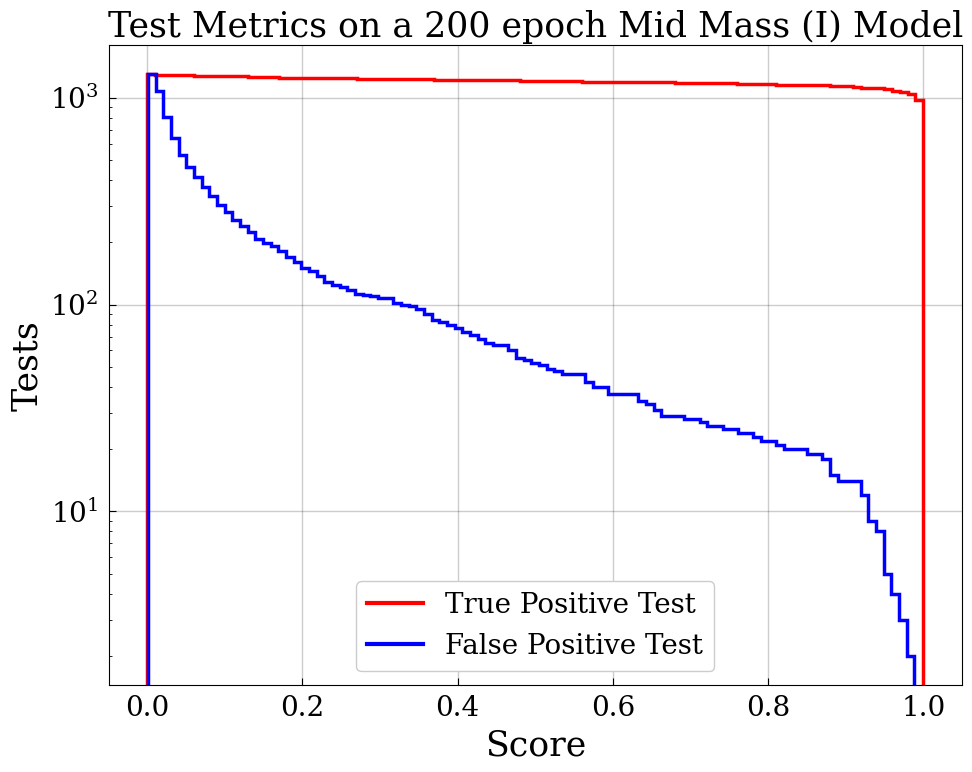

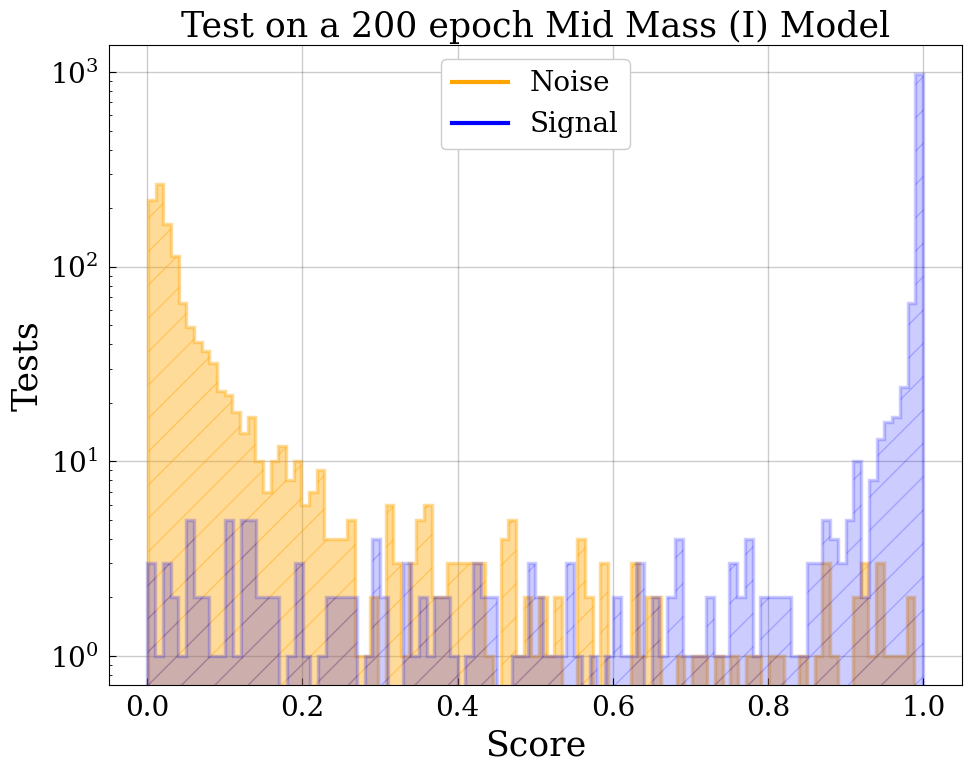

In [15]:
dirs = '/data/danibelt/CNN/Classifier/Mid_mass_I/Run 10 - 3 ResNet, Last mod/Classifier_epochs200'


model = tf.keras.models.load_model(dirs)

test_Y_pred = model.predict(test_X_series)

# por la forma de haber construido la base de datos, las series impares corresponden a ruido

# True Positive Test -- plot noise series

figure_features()
fig = plt.figure(figsize=(10,8))
plt.hist(test_Y_pred[0::2],bins=100,histtype='step',color='red', cumulative=-1, linewidth=2.5, label= "True Positive Test")
plt.hist(test_Y_pred[1::2],bins=100,histtype='step',color='blue', cumulative=-1, linewidth=2.5, label= "False Positive Test")
plt.ylabel('Tests', fontsize=25)
plt.xlabel('Score', fontsize=25)
plt.yscale("log")
plt.title("Test Metrics on a 200 epoch Mid Mass (I) Model", fontsize=25, y=1.0)
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


labels = ['True Positive Test', 'False Positive Test']
handle1 = matplotlib.lines.Line2D([], [], c='r')
handle2 = matplotlib.lines.Line2D([], [], c='b')
leg = plt.legend(handles=[handle1, handle2],labels=labels, loc='lower center', prop={'size':20})

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.tight_layout()
plt.savefig('Images_Report/Classifier/Mid_mass_I/TP_FP.png', dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)



# Test -- plot noise and signal series

figure_features()
fig = plt.figure(figsize=(10,8)) 
plt.hist(test_Y_pred[1::2],bins=100,histtype='step',color='orange', linewidth=2.5, label= "Noise", hatch='/', facecolor='orange', alpha=0.4, fill=True)
plt.hist(test_Y_pred[0::2],bins=100,histtype='step',color='blue', linewidth=2.5, label= "Signal", hatch='/', facecolor='blue', alpha=0.2, fill=True)
plt.ylabel('Tests', fontsize=25)
plt.xlabel('Score', fontsize=25)
plt.yscale("log")
plt.title("Test on a 200 epoch Mid Mass (I) Model", fontsize=25, y=1.0)
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

labels = ['Noise', 'Signal']
handle1 = matplotlib.lines.Line2D([], [], c='orange')
handle2 = matplotlib.lines.Line2D([], [], c='blue')
leg = plt.legend(handles=[handle1, handle2],labels=labels, loc='upper center', prop={'size':20})

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)


plt.tight_layout()
plt.savefig('Images_Report/Classifier/Mid_mass_I/Test_general.png', dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)



## Graficas Mid Mass II - Clasificación


In [16]:
# Definimos unas funciones para cargar los datos, procesarlos y prepararlos como input a la CNN:

def load_data(name, purpose):

        """
        # Loads the data for a given path, yielding a type pycbc.timeseries.TimeSeries
        # ----------------------------------------------------------------------------

        # Arguments:
        # name -- name of the file with extention
        # purpose -- to complete path, must contain 'train' or 'test' and 'signal' or 'noise'

        # Return:
        # data -- dictionary with data, time duration, and frecuency sample
        
        """

               
        if purpose[0] == 'train':
            if purpose[1] == 'signal':
                aux_path = training_se_signal_dir
            if purpose[1] == 'noise':
                aux_path = training_se_noise_dir

        elif purpose[0] == 'test':
            if purpose[1] == 'signal':
                aux_path = test_se_signal_dir
            if purpose[1] == 'noise':
                aux_path = test_se_noise_dir
       
        data = pycbc.types.timeseries.load_timeseries(aux_path + '/' + name)
        

        return data
    



##############################################   RETURN   ##############################################################################
class GW_data_generator():

    
    # This class will generate an array of temporal series, each row of the array being a GW series, and also will generate its corresponding
    # result (0 for noise, 1 fopr signal), and its chirp mass and mass ratio.
    # ----------------------------------------------------------------------------------------------------------------------------------------
    
    
    def __init__(self, record):
        self.record = record
        


    def generate_indexes(self):
        """
        This function will generate a list of numbers shuffled to identify the series
        """
        idx_list = np.random.permutation(len(self.record)) # we shuffle the training samples

        return idx_list

    
    def process_data(self, name, purpose):

        
        # Process an input data given by returning information about it such as duration and sample rate, 
        # and whitening data, bandpassing, normalising and returning an array
        # -----------------------------------------------------------------------------------------------

        # Arguments:
        # name -- name of the file with extention
        # purpose -- to complete path, must contain 'train' or 'test' and 'signal' or 'noise'

        # Return:
        # dictionary type with duration, sample rate, and array in numpy type and TimeSeries type

        
        data = load_data(name, purpose) 
        length = len(data)

        segment_duration = data.get_duration()
        sample_rate = data.get_sample_rate()
        max_filter_duration = segment_duration / 4
        frec_low_cutoff = 30
        frec_high_cutoff = 200


        # whiten the data
        data = data.whiten(segment_duration, max_filter_duration, remove_corrupted=True, low_frequency_cutoff=frec_low_cutoff, return_psd=False)

        # bandpass
        data = data.lowpass_fir(frec_high_cutoff, 8, beta=5.0, remove_corrupted=True) # bandpassing: supress data for frec>300
        data = data.highpass_fir(frec_low_cutoff, 8, beta=5.0, remove_corrupted=True) # bandpassing: supress data for frec<30

        # normalising data to 1
        data = data / max(data)

        # append zeros to beginning and end of the data to keep the input shape unchanged after cropping corrupted segments
        
        length_cr = len(data)
        dif = length-length_cr
        data.prepend_zeros(int(dif / 2)) # append zeros at beginning
        data.append_zeros(int(dif / 2)) # append zeros at end
        

        # return an array
        data = np.squeeze(np.array(data))

        return data

    def generate_series(self, series_idx, purpose, processing):

        
        # Used to generate a batch with series when training/validating/testing our model.
        # -------------------------------------------------------------------------------

        # Arguments:
        # series_idx -- series identification number iloc: if 1050 images, then it takes num in [0,1050]
        # is_training = True
        # purpose -- neccesary to specify directory path
        # batch_size -- len of the batch to b considered

        # Returns:
        # series array containing the temporal series
        # result -- array with corresponding 0 for noise and 1 for signal
        # chirp mass -- array containing corresponding chirp mass of signal series
        # mass ratio -- array containing corresponding mass ratio of signal series

        # Raise:
        # ValueError: Batch size must be multiple of 2 to contain same number of noise than signal series in each batch

        
        # arrays to store our batched data
        series, result = np.empty((1,int(3*2048)),dtype=float), np.array([])
        #chirpM, qratio = [], []
        
        for idx in (series_idx): #tqdm.tqdm

            ######   WE APPEND A SIGNAL SERIES  ########
            aux_purpose = 'signal'
            parameters = self.record.iloc[idx] # returns the row of data corresponding to such series iloc
            file_name = parameters['Ref.Name']    

            # here we load the data and process it according to signal or noise

            # with processing
            if processing == True:    
                series_np = self.process_data(file_name, [purpose, aux_purpose])
            # with no processing
            if processing == False:
                series_np = np.array(load_data(file_name, [purpose, aux_purpose]))

            
            result = np.hstack((result, 1))
            """
            chirp = parameters['Chirp mass']
            qM = parameters['Mass ratio']

            chirpM.append(chirp)
            qratio.append(qM)
            """
            series = np.vstack((series, series_np))


            # once appended a signal value, now we append a noise value

            #######  WE APPEND A NOISE SERIES  ##########
            aux_purpose = 'noise'
            if purpose == 'train':
                aux_path = training_se_noise_dir
            elif purpose == 'test':
                aux_path = 'test_se_noise_dir'
            #it = np.random.randint(1, len(os.listdir(aux_path)))
            file_name = 'noise_sample{}.hdf'.format(idx+1) # csv indexes gows from 0 to ..., but noise samples goes from 1 to ...

            # with processing
            if processing == True:    
                series_np = self.process_data(file_name, [purpose, aux_purpose])
                                
            # with no processing
            if processing == False:
                #input_shape = series_np.shape()
                series_np = np.array(load_data(file_name, [purpose, aux_purpose]))
                

            result = np.hstack((result, 0))
            series = np.vstack((series, series_np))

            
        series = np.delete(series, 0, axis=0) # delete first row of np.empty
        return series, result
 

In [17]:
file_name = 'CNN_Images_Run35_m1_m2_mid_mass_II'

"""
CNN_Images_Run35_m1_m2_low_mass
CNN_Images_Run35_m1_m2_mid_mass_I
CNN_Images_Run35_m1_m2_mid_mass_II
CNN_Images_Run35_m1_m2_high_mass
"""

root_dir = '/data/danibelt/Images_Series_Chirp_Ratio_1/'
#root_dir = '/run/user/1001/gvfs/sftp:host=pcaecuda2,user=danibelt/data/danibelt/Images_Series_Chirp_Ratio_1/'


base_dir = os.path.join(root_dir, file_name)

# training and test path (2)
training_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

# series and images paths, two per previous path (4)
image_tr_dir = os.path.join(training_dir, 'Images')
image_te_dir = os.path.join(test_dir, 'Images')
series_tr_dir = os.path.join(training_dir, 'Series')
series_te_dir = os.path.join(test_dir, 'Series')

# signal and noise paths, two per previous path (8)
training_se_signal_dir = os.path.join(series_tr_dir, 'Signal')
training_se_noise_dir = os.path.join(series_tr_dir, 'Noise')

test_se_signal_dir = os.path.join(series_te_dir, 'Signal')
test_se_noise_dir = os.path.join(series_te_dir, 'Noise')


# We opne .csv file and append extentions .png and .hdf where needed.

# for SERIES
record_path_train = os.path.join(series_tr_dir,'Records_training_signal.csv')
record_train_series = pd.read_csv(record_path_train, sep='\t')

record_path_test = os.path.join(series_te_dir,'Records_test_signal.csv')
record_test_series = pd.read_csv(record_path_test, sep='\t')


def append_ext_png(fn):
    return fn+".png"

def append_ext_hdf(fn):
    return fn+".hdf"

# for SERIES
record_test_series["Ref.Name"]=record_test_series["Ref.Name"].apply(append_ext_hdf)


# test set of series 

data_generator_test = GW_data_generator(record_test_series)
test_idx = data_generator_test.generate_indexes()
test_X_series, _ = data_generator_test.generate_series(test_idx, purpose='test', processing=True)



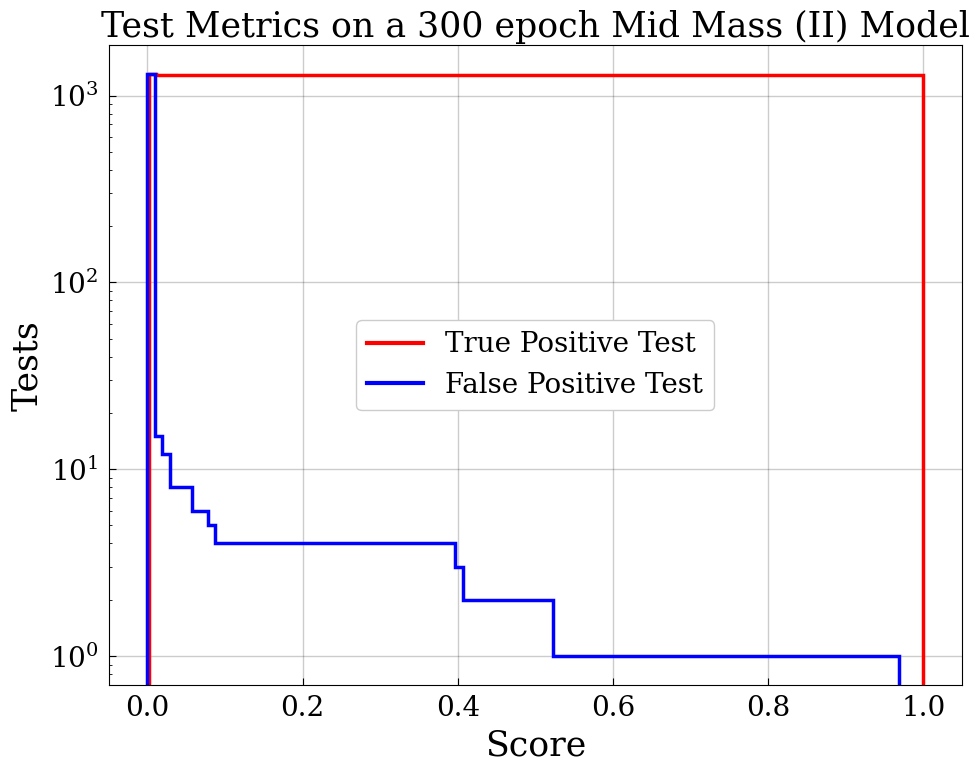

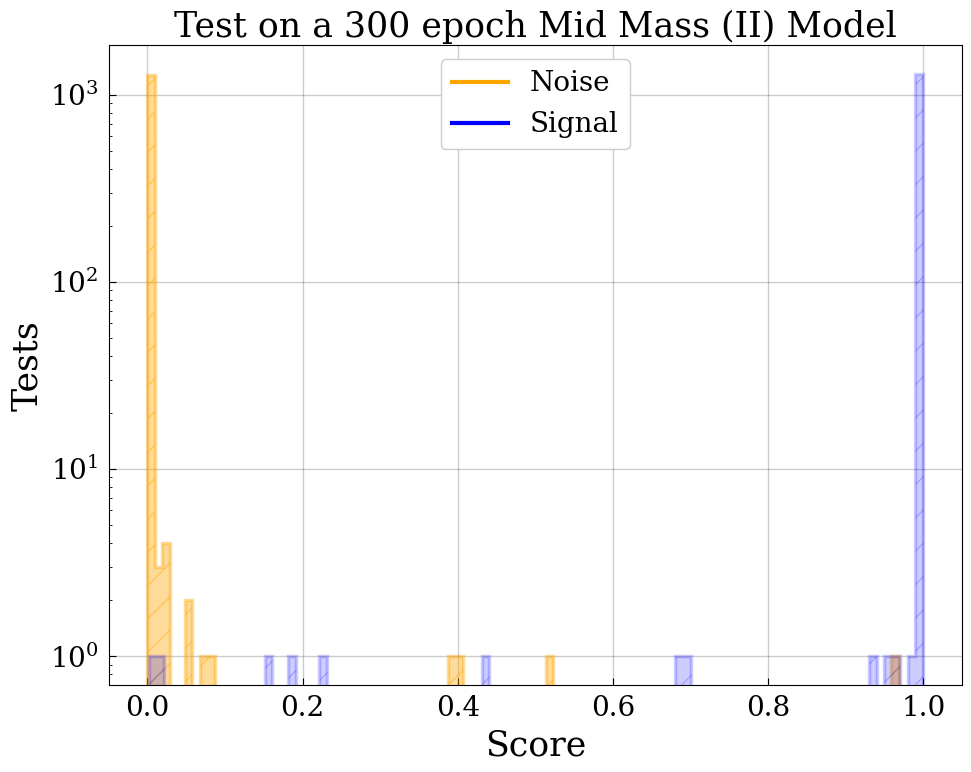

In [19]:
dirs = '/data/danibelt/CNN/Classifier/Mid_mass_II/Run 10 - 3 ResNet, Last mod/Classifier_epochs300'


model = tf.keras.models.load_model(dirs)

test_Y_pred = model.predict(test_X_series)

# por la forma de haber construido la base de datos, las series impares corresponden a ruido

# True Positive Test -- plot noise series

figure_features()
fig = plt.figure(figsize=(10,8))
plt.hist(test_Y_pred[0::2],bins=100,histtype='step',color='red', cumulative=-1, linewidth=2.5, label= "True Positive Test")
plt.hist(test_Y_pred[1::2],bins=100,histtype='step',color='blue', cumulative=-1, linewidth=2.5, label= "False Positive Test")
plt.ylabel('Tests', fontsize=25)
plt.xlabel('Score', fontsize=25)
plt.yscale("log")
plt.title("Test Metrics on a 300 epoch Mid Mass (II) Model", fontsize=25, y=1.0)
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

labels = ['True Positive Test', 'False Positive Test']
handle1 = matplotlib.lines.Line2D([], [], c='r')
handle2 = matplotlib.lines.Line2D([], [], c='b')
leg = plt.legend(handles=[handle1, handle2],labels=labels, loc='center', prop={'size':20})

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.tight_layout()
plt.savefig('Images_Report/Classifier/Mid_mass_II/TP_FP.png', dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)



# Test -- plot noise and signal series

figure_features()
fig = plt.figure(figsize=(10,8)) 
plt.hist(test_Y_pred[1::2],bins=100,histtype='step',color='orange', linewidth=2.5, label= "Noise", hatch='/', facecolor='orange', alpha=0.4, fill=True)
plt.hist(test_Y_pred[0::2],bins=100,histtype='step',color='blue', linewidth=2.5, label= "Signal", hatch='/', facecolor='blue', alpha=0.2, fill=True)
plt.ylabel('Tests', fontsize=25)
plt.xlabel('Score', fontsize=25)
plt.yscale("log")
plt.title("Test on a 300 epoch Mid Mass (II) Model", fontsize=25, y=1.0)
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

labels = ['Noise', 'Signal']
handle1 = matplotlib.lines.Line2D([], [], c='orange')
handle2 = matplotlib.lines.Line2D([], [], c='blue')
leg = plt.legend(handles=[handle1, handle2],labels=labels, loc='upper center', prop={'size':20})

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)


plt.tight_layout()
plt.savefig('Images_Report/Classifier/Mid_mass_II/Test_general.png', dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)



## Graficas High Mass - Clasificación


In [2]:
# Definimos unas funciones para cargar los datos, procesarlos y prepararlos como input a la CNN:

def load_data(name, purpose):

        """
        # Loads the data for a given path, yielding a type pycbc.timeseries.TimeSeries
        # ----------------------------------------------------------------------------

        # Arguments:
        # name -- name of the file with extention
        # purpose -- to complete path, must contain 'train' or 'test' and 'signal' or 'noise'

        # Return:
        # data -- dictionary with data, time duration, and frecuency sample
        
        """

               
        if purpose[0] == 'train':
            if purpose[1] == 'signal':
                aux_path = training_se_signal_dir
            if purpose[1] == 'noise':
                aux_path = training_se_noise_dir

        elif purpose[0] == 'test':
            if purpose[1] == 'signal':
                aux_path = test_se_signal_dir
            if purpose[1] == 'noise':
                aux_path = test_se_noise_dir
       
        data = pycbc.types.timeseries.load_timeseries(aux_path + '/' + name)
        

        return data
    



##############################################   RETURN   ##############################################################################
class GW_data_generator():

    
    # This class will generate an array of temporal series, each row of the array being a GW series, and also will generate its corresponding
    # result (0 for noise, 1 fopr signal), and its chirp mass and mass ratio.
    # ----------------------------------------------------------------------------------------------------------------------------------------
    
    
    def __init__(self, record):
        self.record = record
        


    def generate_indexes(self):
        """
        This function will generate a list of numbers shuffled to identify the series
        """
        idx_list = np.random.permutation(len(self.record)) # we shuffle the training samples

        return idx_list

    
    def process_data(self, name, purpose):

        
        # Process an input data given by returning information about it such as duration and sample rate, 
        # and whitening data, bandpassing, normalising and returning an array
        # -----------------------------------------------------------------------------------------------

        # Arguments:
        # name -- name of the file with extention
        # purpose -- to complete path, must contain 'train' or 'test' and 'signal' or 'noise'

        # Return:
        # dictionary type with duration, sample rate, and array in numpy type and TimeSeries type

        
        data = load_data(name, purpose) 
        length = len(data)

        segment_duration = data.get_duration()
        sample_rate = data.get_sample_rate()
        max_filter_duration = segment_duration / 4
        frec_low_cutoff = 30
        frec_high_cutoff = 200


        # whiten the data
        data = data.whiten(segment_duration, max_filter_duration, remove_corrupted=True, low_frequency_cutoff=frec_low_cutoff, return_psd=False)

        # bandpass
        data = data.lowpass_fir(frec_high_cutoff, 8, beta=5.0, remove_corrupted=True) # bandpassing: supress data for frec>300
        data = data.highpass_fir(frec_low_cutoff, 8, beta=5.0, remove_corrupted=True) # bandpassing: supress data for frec<30

        # normalising data to 1
        data = data / max(data)

        # append zeros to beginning and end of the data to keep the input shape unchanged after cropping corrupted segments
        
        length_cr = len(data)
        dif = length-length_cr
        data.prepend_zeros(int(dif / 2)) # append zeros at beginning
        data.append_zeros(int(dif / 2)) # append zeros at end
        

        # return an array
        data = np.squeeze(np.array(data))

        return data

    def generate_series(self, series_idx, purpose, processing):

        
        # Used to generate a batch with series when training/validating/testing our model.
        # -------------------------------------------------------------------------------

        # Arguments:
        # series_idx -- series identification number iloc: if 1050 images, then it takes num in [0,1050]
        # is_training = True
        # purpose -- neccesary to specify directory path
        # batch_size -- len of the batch to b considered

        # Returns:
        # series array containing the temporal series
        # result -- array with corresponding 0 for noise and 1 for signal
        # chirp mass -- array containing corresponding chirp mass of signal series
        # mass ratio -- array containing corresponding mass ratio of signal series

        # Raise:
        # ValueError: Batch size must be multiple of 2 to contain same number of noise than signal series in each batch

        
        # arrays to store our batched data
        series, result = np.empty((1,int(3*2048)),dtype=float), np.array([])
        #chirpM, qratio = [], []
        
        for idx in (series_idx): #tqdm.tqdm

            ######   WE APPEND A SIGNAL SERIES  ########
            aux_purpose = 'signal'
            parameters = self.record.iloc[idx] # returns the row of data corresponding to such series iloc
            file_name = parameters['Ref.Name']    

            # here we load the data and process it according to signal or noise

            # with processing
            if processing == True:    
                series_np = self.process_data(file_name, [purpose, aux_purpose])
            # with no processing
            if processing == False:
                series_np = np.array(load_data(file_name, [purpose, aux_purpose]))

            
            result = np.hstack((result, 1))
            """
            chirp = parameters['Chirp mass']
            qM = parameters['Mass ratio']

            chirpM.append(chirp)
            qratio.append(qM)
            """
            series = np.vstack((series, series_np))


            # once appended a signal value, now we append a noise value

            #######  WE APPEND A NOISE SERIES  ##########
            aux_purpose = 'noise'
            if purpose == 'train':
                aux_path = training_se_noise_dir
            elif purpose == 'test':
                aux_path = 'test_se_noise_dir'
            #it = np.random.randint(1, len(os.listdir(aux_path)))
            file_name = 'noise_sample{}.hdf'.format(idx+1) # csv indexes gows from 0 to ..., but noise samples goes from 1 to ...

            # with processing
            if processing == True:    
                series_np = self.process_data(file_name, [purpose, aux_purpose])
                                
            # with no processing
            if processing == False:
                #input_shape = series_np.shape()
                series_np = np.array(load_data(file_name, [purpose, aux_purpose]))
                

            result = np.hstack((result, 0))
            series = np.vstack((series, series_np))

            
        series = np.delete(series, 0, axis=0) # delete first row of np.empty
        return series, result
 

In [3]:
file_name = 'CNN_Images_Run35_m1_m2_high_mass'

"""
CNN_Images_Run35_m1_m2_low_mass
CNN_Images_Run35_m1_m2_mid_mass_I
CNN_Images_Run35_m1_m2_mid_mass_II
CNN_Images_Run35_m1_m2_high_mass
"""

root_dir = '/data/danibelt/Images_Series_Chirp_Ratio_1/'
#root_dir = '/run/user/1001/gvfs/sftp:host=pcaecuda2,user=danibelt/data/danibelt/Images_Series_Chirp_Ratio_1/'


base_dir = os.path.join(root_dir, file_name)

# training and test path (2)
training_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

# series and images paths, two per previous path (4)
image_tr_dir = os.path.join(training_dir, 'Images')
image_te_dir = os.path.join(test_dir, 'Images')
series_tr_dir = os.path.join(training_dir, 'Series')
series_te_dir = os.path.join(test_dir, 'Series')

# signal and noise paths, two per previous path (8)
training_se_signal_dir = os.path.join(series_tr_dir, 'Signal')
training_se_noise_dir = os.path.join(series_tr_dir, 'Noise')

test_se_signal_dir = os.path.join(series_te_dir, 'Signal')
test_se_noise_dir = os.path.join(series_te_dir, 'Noise')


# We opne .csv file and append extentions .png and .hdf where needed.

# for SERIES
record_path_train = os.path.join(series_tr_dir,'Records_training_signal.csv')
record_train_series = pd.read_csv(record_path_train, sep='\t')

record_path_test = os.path.join(series_te_dir,'Records_test_signal.csv')
record_test_series = pd.read_csv(record_path_test, sep='\t')


def append_ext_png(fn):
    return fn+".png"

def append_ext_hdf(fn):
    return fn+".hdf"

# for SERIES
record_test_series["Ref.Name"]=record_test_series["Ref.Name"].apply(append_ext_hdf)


# test set of series 

data_generator_test = GW_data_generator(record_test_series)
test_idx = data_generator_test.generate_indexes()
test_X_series, _ = data_generator_test.generate_series(test_idx, purpose='test', processing=True)



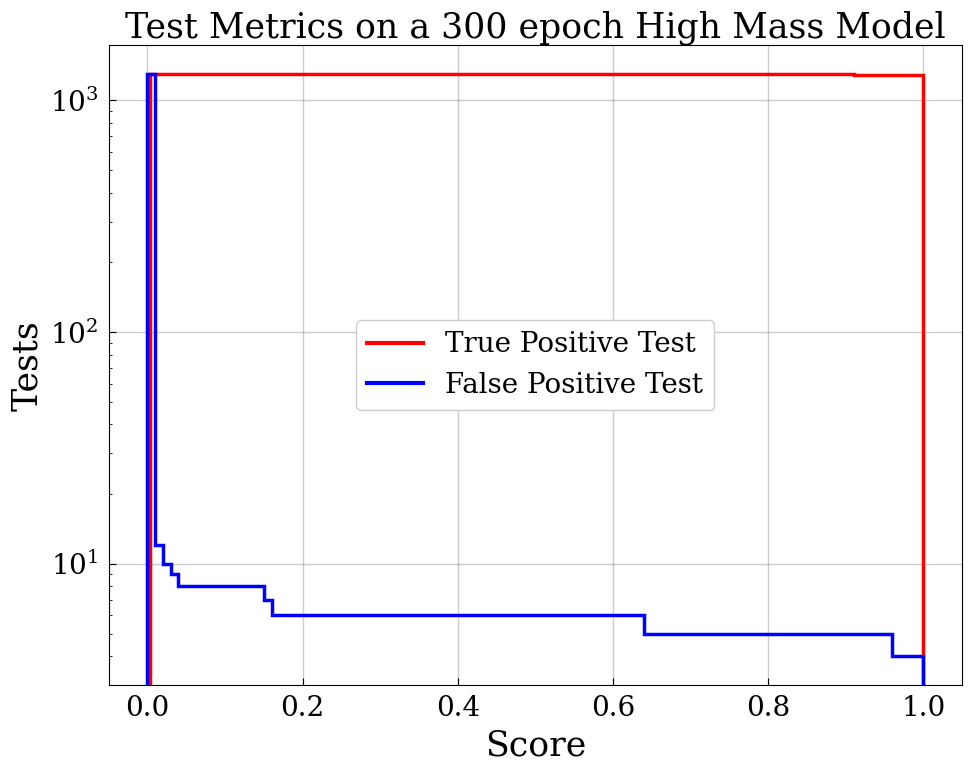

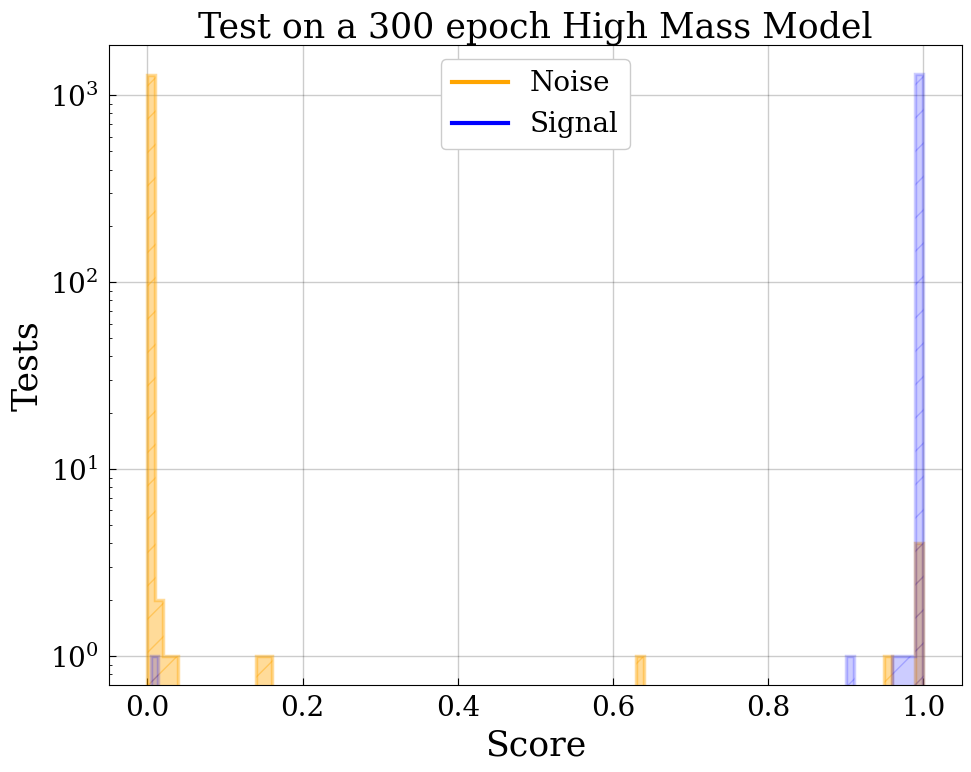

In [5]:
dirs = '/data/danibelt/CNN/Classifier/High_mass/Run 10 - 3 ResNet, Last mod/Classifier_epochs300'


model = tf.keras.models.load_model(dirs)

test_Y_pred = model.predict(test_X_series)

# por la forma de haber construido la base de datos, las series impares corresponden a ruido

# True Positive Test -- plot noise series

figure_features()
fig = plt.figure(figsize=(10,8))
plt.hist(test_Y_pred[0::2],bins=100,histtype='step',color='red', cumulative=-1, linewidth=2.5, label= "True Positive Test")
plt.hist(test_Y_pred[1::2],bins=100,histtype='step',color='blue', cumulative=-1, linewidth=2.5, label= "False Positive Test")
plt.ylabel('Tests', fontsize=25)
plt.xlabel('Score', fontsize=25)
plt.yscale("log")
plt.title("Test Metrics on a 300 epoch High Mass Model", fontsize=25)
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

labels = ['True Positive Test', 'False Positive Test']
handle1 = matplotlib.lines.Line2D([], [], c='r')
handle2 = matplotlib.lines.Line2D([], [], c='b')
leg = plt.legend(handles=[handle1, handle2],labels=labels, loc='center', prop={'size':20})

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.tight_layout()
plt.savefig('Images_Report/Classifier/High_mass/TP_FP.png', dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)



# Test -- plot noise and signal series

figure_features()
fig = plt.figure(figsize=(10,8)) 
plt.hist(test_Y_pred[1::2],bins=100,histtype='step',color='orange', linewidth=2.5, label= "Noise", hatch='/', facecolor='orange', alpha=0.4, fill=True)
plt.hist(test_Y_pred[0::2],bins=100,histtype='step',color='blue', linewidth=2.5, label= "Signal", hatch='/', facecolor='blue', alpha=0.2, fill=True)
plt.ylabel('Tests', fontsize=25)
plt.xlabel('Score', fontsize=25)
plt.yscale("log")
plt.title("Test on a 300 epoch High Mass Model", fontsize=25)
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

labels = ['Noise', 'Signal']
handle1 = matplotlib.lines.Line2D([], [], c='orange')
handle2 = matplotlib.lines.Line2D([], [], c='blue')
leg = plt.legend(handles=[handle1, handle2],labels=labels, loc='upper center', prop={'size':20})

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)


plt.tight_layout()
plt.savefig('Images_Report/Classifier/High_mass/Test_general.png', dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)



## Grafica Low mass - Regresor

In [23]:
# Definimos unas funciones para cargar los datos, procesarlos y prepararlos como input a la CNN:

def load_data(name, purpose):

        """
        # Loads the data for a given path, yielding a type pycbc.timeseries.TimeSeries
        # ----------------------------------------------------------------------------

        # Arguments:
        # name -- name of the file with extention
        # purpose -- to complete path, must contain 'train' or 'test' and 'signal' or 'noise'

        # Return:
        # data -- dictionary with data, time duration, and frecuency sample
        
        """

               
               
        if purpose == 'train':
            aux_path = training_se_signal_dir
            
        elif purpose == 'test':
            aux_path = test_se_signal_dir
            
        data = pycbc.types.timeseries.load_timeseries(aux_path + '/' + name)
      

        return data
    




##############################   REUTURN    #####################################
class GW_data_generator():

    """
    This class will generate an array of temporal series, each row of the array being a GW series, and also will generate its corresponding
    result (0 for noise, 1 fopr signal), and its chirp mass and mass ratio.
    ----------------------------------------------------------------------------------------------------------------------------------------
    """
    
    def __init__(self, record):
        self.record = record
        


    def generate_indexes(self):
        """
        This function will generate a list of numbers shuffled to identify the series
        """
        idx_list = np.random.permutation(len(self.record)) # we shuffle the training samples

        return idx_list

    
    def process_data(self, name, purpose):

        """
        Process an input data given by returning information about it such as duration and sample rate, 
        and whitening data, bandpassing, normalising and returning an array
        -----------------------------------------------------------------------------------------------

        Arguments:
        name -- name of the file with extention
        purpose -- to complete path, must contain 'train' or 'test' and 'signal' or 'noise'

        Return:
        dictionary type with duration, sample rate, and array in numpy type and TimeSeries type

        """
        data = load_data(name, purpose) 
        length = len(data)

        segment_duration = data.get_duration()
        sample_rate = data.get_sample_rate()
        max_filter_duration = segment_duration / 4
        frec_low_cutoff = 30
        frec_high_cutoff = 200


        # whiten the data
        data = data.whiten(segment_duration, max_filter_duration, remove_corrupted=True, low_frequency_cutoff=frec_low_cutoff, return_psd=False)

        # bandpass
        data = data.lowpass_fir(frec_high_cutoff, 8, beta=5.0, remove_corrupted=True) # bandpassing: supress data for frec>300
        data = data.highpass_fir(frec_low_cutoff, 8, beta=5.0, remove_corrupted=True) # bandpassing: supress data for frec<30

        # normalising data to 1
        data = data / max(data)

        # append zeros to beginning and end of the data to keep the input shape unchanged after cropping corrupted segments
        
        length_cr = len(data)
        dif = length-length_cr
        data.prepend_zeros(int(dif / 2)) # append zeros at beginning
        data.append_zeros(int(dif / 2)) # append zeros at end
        

        # return an array
        data = np.squeeze(np.array(data))

        return data

    def generate_series(self, series_idx, purpose, processing):

        """
        Used to generate a batch with series when training/validating/testing our model.
        -------------------------------------------------------------------------------

        Arguments:
        series_idx -- series identification number iloc: if 1050 images, then it takes num in [0,1050]
        is_training = True
        purpose -- neccesary to specify directory path
        batch_size -- len of the batch to b considered

        Returns:
        series array containing the temporal series
        result -- array with corresponding 0 for noise and 1 for signal
        chirp mass -- array containing corresponding chirp mass of signal series
        mass ratio -- array containing corresponding mass ratio of signal series

        Raise:
        ValueError: Batch size must be multiple of 2 to contain same number of noise than signal series in each batch

        """
        


        # arrays to store our batched data
        series = np.empty((1,int(3*2048)),dtype=float)
        chirpM = np.array([])
        qratio = np.array([])
        

        for idx in (series_idx): #tqdm.tqdm

            ######   WE APPEND A SIGNAL SERIES  ########
            parameters = self.record.iloc[idx] # returns the row of data corresponding to such series iloc
            file_name = parameters['Ref.Name']    

            # here we load the data and process it according to signal or noise

            # with processing
            if processing == True:    
                series_np = self.process_data(file_name, purpose)
            # with no processing
            if processing == False:
                series_np = np.array(load_data(file_name, purpose))

            
            chirpM = np.hstack((chirpM, parameters['Chirp mass']))  
            qratio = np.hstack((qratio, parameters['Mass ratio']))    
                   
            series = np.vstack((series, series_np))
        
        series = np.delete(series, 0, axis=0) # delete first row of np.empty

        return series, chirpM, qratio

In [24]:
file_name = 'CNN_Images_Run35_m1_m2_low_mass'

"""
CNN_Images_Run35_m1_m2_low_mass
CNN_Images_Run35_m1_m2_mid_mass_I
CNN_Images_Run35_m1_m2_mid_mass_II
CNN_Images_Run35_m1_m2_high_mass
"""

root_dir = '/data/danibelt/Images_Series_Chirp_Ratio_1/'
#root_dir = '/run/user/1001/gvfs/sftp:host=pcaecuda2,user=danibelt/data/danibelt/Images_Series_Chirp_Ratio_1/'


base_dir = os.path.join(root_dir, file_name)

# training and test path (2)
training_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

# series and images paths, two per previous path (4)
image_tr_dir = os.path.join(training_dir, 'Images')
image_te_dir = os.path.join(test_dir, 'Images')
series_tr_dir = os.path.join(training_dir, 'Series')
series_te_dir = os.path.join(test_dir, 'Series')

# signal and noise paths, two per previous path (8)
training_se_signal_dir = os.path.join(series_tr_dir, 'Signal')
training_se_noise_dir = os.path.join(series_tr_dir, 'Noise')

test_se_signal_dir = os.path.join(series_te_dir, 'Signal')
test_se_noise_dir = os.path.join(series_te_dir, 'Noise')


# We opne .csv file and append extentions .png and .hdf where needed.

# for SERIES
record_path_train = os.path.join(series_tr_dir,'Records_training_signal.csv')
record_train_series = pd.read_csv(record_path_train, sep='\t')

record_path_test = os.path.join(series_te_dir,'Records_test_signal.csv')
record_test_series = pd.read_csv(record_path_test, sep='\t')


def append_ext_png(fn):
    return fn+".png"

def append_ext_hdf(fn):
    return fn+".hdf"

# for SERIES
record_test_series["Ref.Name"]=record_test_series["Ref.Name"].apply(append_ext_hdf)


# test set of series 

data_generator_test = GW_data_generator(record_test_series)
test_idx = data_generator_test.generate_indexes()
test_X_series, test_Y1_series, test_Y2_series = data_generator_test.generate_series(test_idx, purpose='test', processing=True)


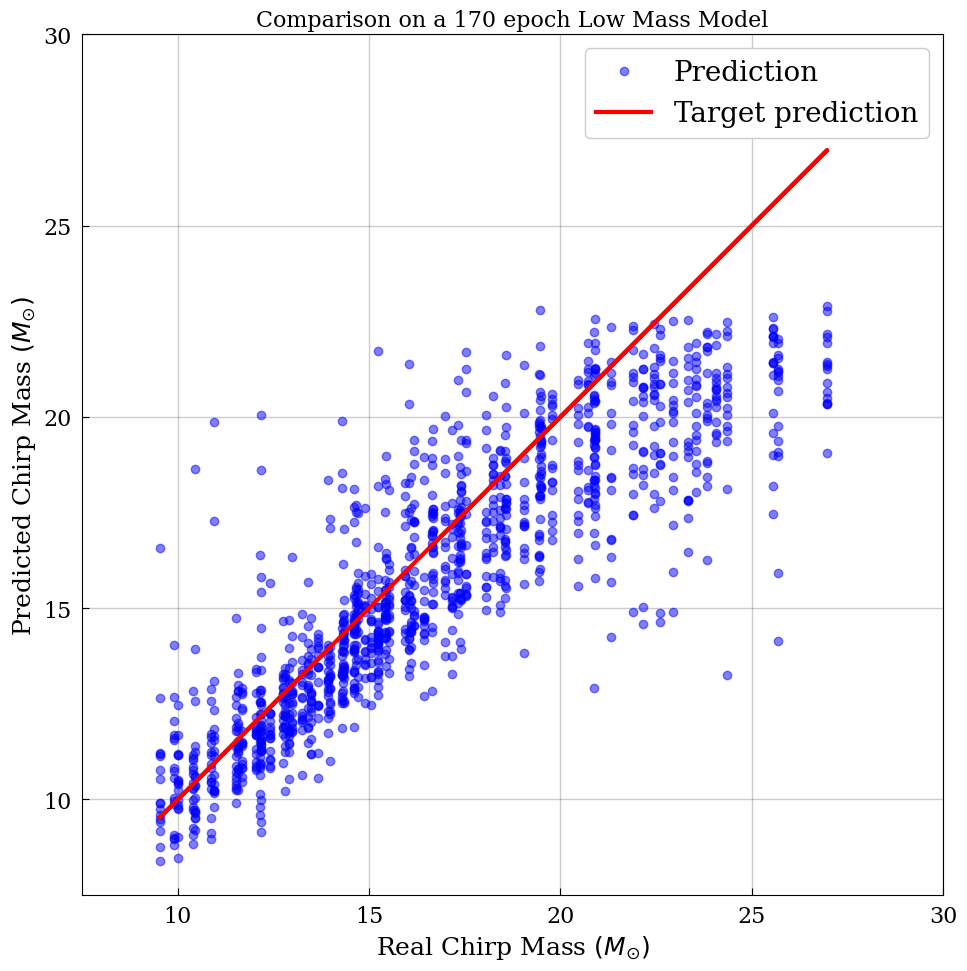

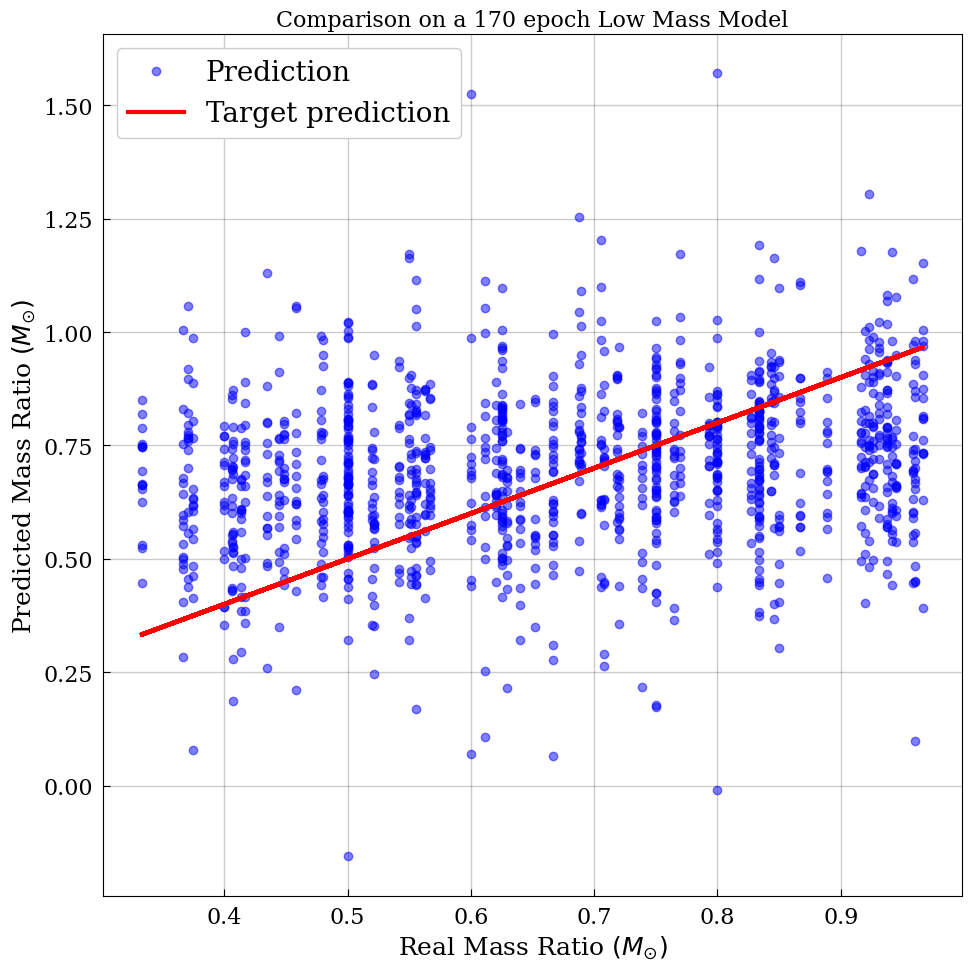

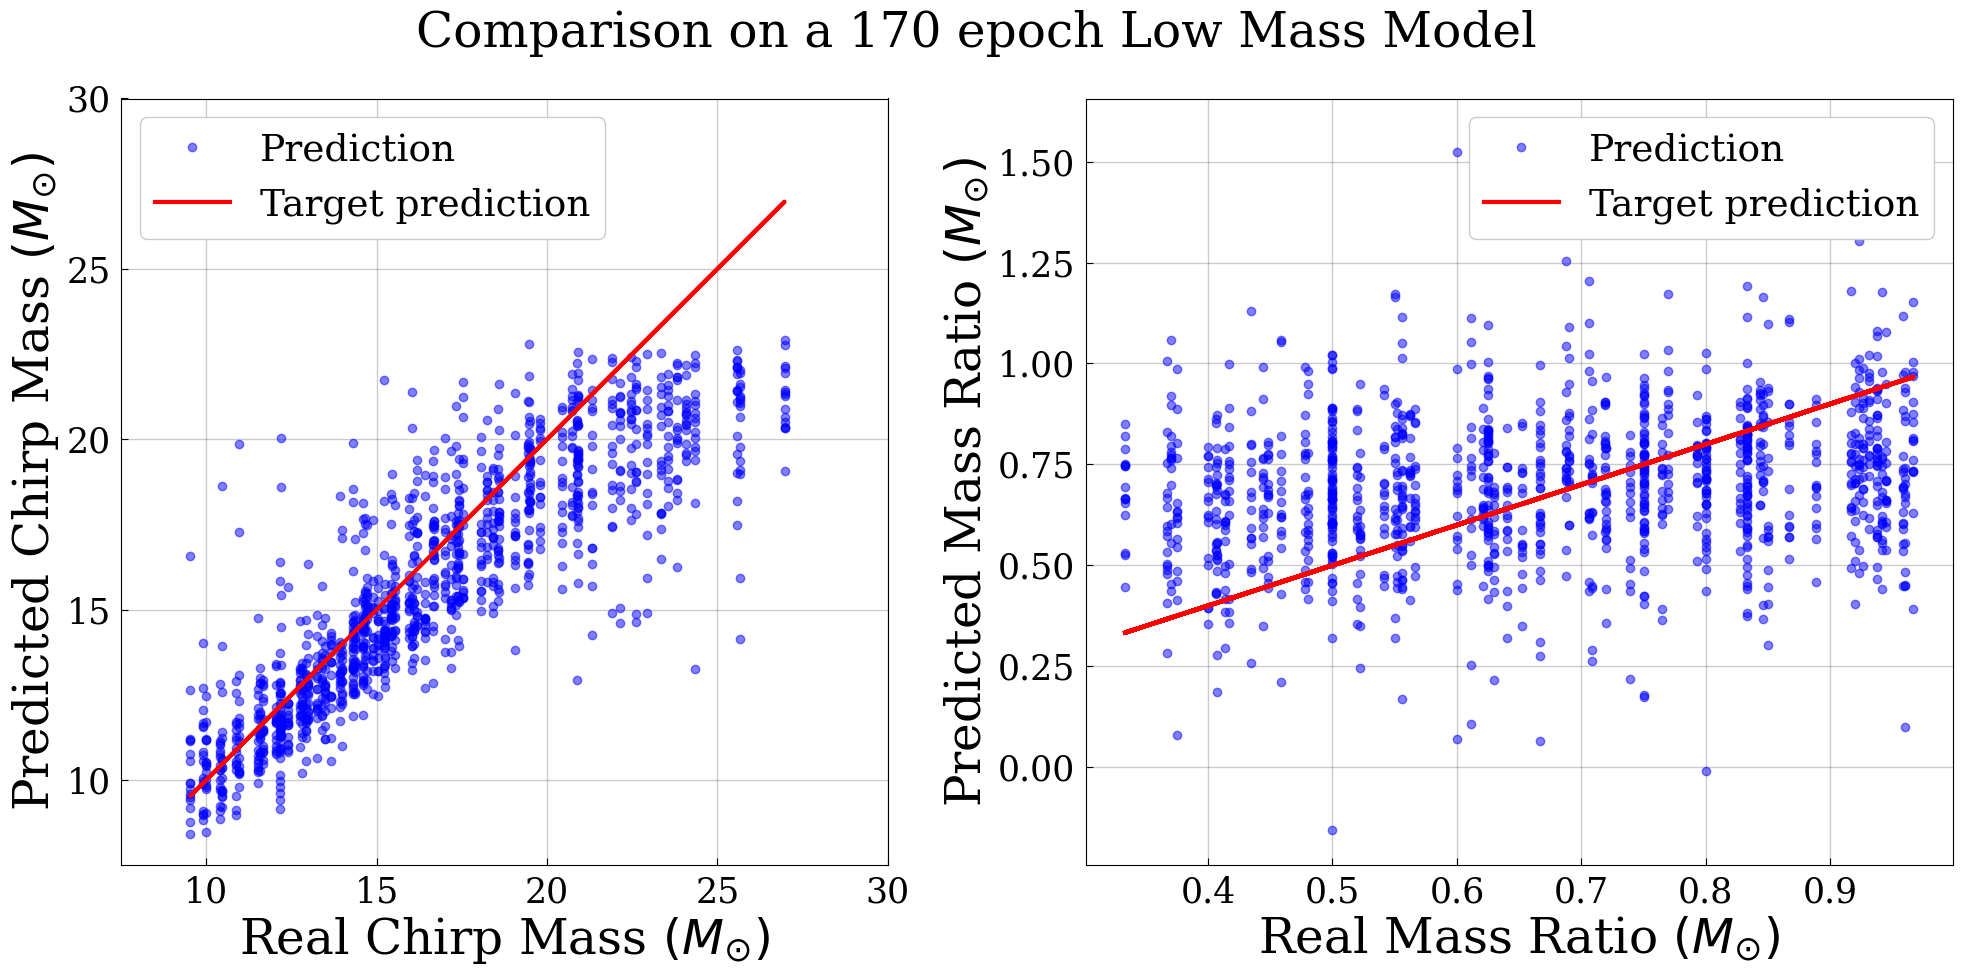

In [35]:
dirs = '/data/danibelt/CNN/2D/Low_mass/Run 10 - 3 ResNet, Last mod/Classifier_epochs170'


model = tf.keras.models.load_model(dirs)

test_Y1_pred, test_Y2_pred = model.predict(test_X_series)


# Test -- Y pred vs Y series CHIRP

figure_features()
fig = plt.figure(figsize=(10,10)) 
plt.plot(test_Y1_series, test_Y1_pred, 'o', color='blue', alpha=0.5, label='Prediction')
plt.plot(test_Y1_series, test_Y1_series, color='red', linewidth=3, alpha=1, label= 'Target prediction')
plt.ylabel('Predicted Chirp Mass '+r'$(M_{\odot})$')
plt.xlabel('Real Chirp Mass '+r'$(M_{\odot})$')
plt.yscale("linear")
plt.title("Comparison on a 170 epoch Low Mass Model")
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.legend(prop={'size':20})

plt.xlim(7.5, 27.5)
plt.ylim(7.5, 27.5)

plt.xticks(np.linspace(10, 30,5))
plt.yticks(np.linspace(10, 30,5))
plt.tight_layout()

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.savefig("Images_Report/Regressor/Low_mass/Chirp_test.png", dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)

# Test -- Y pred vs Y series RATIO

figure_features()
fig = plt.figure(figsize=(10,10)) 
plt.plot(test_Y2_series, test_Y2_pred, 'o', color='blue', alpha=0.5, label='Prediction')
plt.plot(test_Y2_series, test_Y2_series, color='red', linewidth=3, alpha=1, label= 'Target prediction')
plt.ylabel('Predicted Mass Ratio '+r'$(M_{\odot})$')
plt.xlabel('Real Mass Ratio '+r'$(M_{\odot})$')
plt.yscale("linear")
plt.title("Comparison on a 170 epoch Low Mass Model")
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.legend(prop={'size':20})

#plt.xlim(0.1, 1.3)
#plt.ylim(0.1, 1.3)

#plt.xticks(np.linspace(0, 1.5, 5))
#plt.yticks(np.linspace(0, 1.5, 5))
plt.tight_layout()

#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')

plt.savefig("Images_Report/Regressor/Low_mass/Ratio_test.png", dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)



## SUBPLOTS

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), tight_layout=True)
ax1.plot(test_Y1_series, test_Y1_pred, 'o', color='blue', alpha=0.5, label='Prediction')
ax1.plot(test_Y1_series, test_Y1_series, color='red', linewidth=3, alpha=1, label= 'Target prediction')

ax1.set_ylabel('Predicted Chirp Mass '+r'$(M_{\odot})$', fontsize=35)
ax1.set_xlabel('Real Chirp Mass '+r'$(M_{\odot})$', fontsize=35)
ax1.set_yscale("linear")
#ax1.set_title("Comparison on a 170 epoch Low Mass Model", fontsize=30, x=2.0)
ax1.grid(linewidth=1, color='black', alpha=0.2)
ax1.legend(prop={'size':27})

ax1.set_xlim(7.5, 27.5)
ax1.set_ylim(7.5, 27.5)

ax1.set_xticks(np.linspace(10, 30,5))
ax1.set_yticks(np.linspace(10, 30,5))

ax1.set_aspect('equal', adjustable='box')

ax2.plot(test_Y2_series, test_Y2_pred, 'o', color='blue', alpha=0.5, label='Prediction')
ax2.plot(test_Y2_series, test_Y2_series, color='red', linewidth=3, alpha=1, label= 'Target prediction')
ax2.set_ylabel('Predicted Mass Ratio '+r'$(M_{\odot})$', fontsize=35)
ax2.set_xlabel('Real Mass Ratio '+r'$(M_{\odot})$', fontsize=35)
ax2.set_yscale("linear")
#ax2.set_title("Comparison on a 170 epoch Low Mass Model", fontsize=30)
ax2.grid(linewidth=1, color='black', alpha=0.2)
ax2.legend(prop={'size':27})

#ax2.set_xlim(0.1, 1.3)
#ax2.set_ylim(0.1, 1.3)

#plt.xticks(np.linspace(0, 1.5, 5))
#plt.yticks(np.linspace(0, 1.5, 5))

#ax2.set_aspect('equal', adjustable='box')


ax1.yaxis.set_tick_params(labelsize=25)
ax1.xaxis.set_tick_params(labelsize=25)

ax2.yaxis.set_tick_params(labelsize=25)
ax2.xaxis.set_tick_params(labelsize=25)

fig.suptitle("Comparison on a 170 epoch Low Mass Model", fontsize=35)

plt.savefig("Images_Report/Regressor/Low_mass/Chirp_Ratio_test.png", dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)

## COMPUTE RELATIVE ERROR


# Plot Relative Error CHIRP
a = np.reshape(test_Y1_pred,(1,len(test_Y1_pred)))
b = np.reshape(test_Y1_series,(1,len(test_Y1_series)))
rel_err_chirp_LOW = np.squeeze(((a - b) / b) * 100)

# Plot Relative Error RATIO
a = np.reshape(test_Y2_pred,(1,len(test_Y2_pred)))
b = np.reshape(test_Y2_series,(1,len(test_Y2_series)))
rel_err_ratio_LOW = np.squeeze(((a - b) / b) * 100)


## Grafica Mid mass I - Regresor

In [36]:
# Definimos unas funciones para cargar los datos, procesarlos y prepararlos como input a la CNN:

def load_data(name, purpose):

        """
        # Loads the data for a given path, yielding a type pycbc.timeseries.TimeSeries
        # ----------------------------------------------------------------------------

        # Arguments:
        # name -- name of the file with extention
        # purpose -- to complete path, must contain 'train' or 'test' and 'signal' or 'noise'

        # Return:
        # data -- dictionary with data, time duration, and frecuency sample
        
        """

               
               
        if purpose == 'train':
            aux_path = training_se_signal_dir
            
        elif purpose == 'test':
            aux_path = test_se_signal_dir
            
        data = pycbc.types.timeseries.load_timeseries(aux_path + '/' + name)
      

        return data
    




##############################   REUTURN    #####################################
class GW_data_generator():

    """
    This class will generate an array of temporal series, each row of the array being a GW series, and also will generate its corresponding
    result (0 for noise, 1 fopr signal), and its chirp mass and mass ratio.
    ----------------------------------------------------------------------------------------------------------------------------------------
    """
    
    def __init__(self, record):
        self.record = record
        


    def generate_indexes(self):
        """
        This function will generate a list of numbers shuffled to identify the series
        """
        idx_list = np.random.permutation(len(self.record)) # we shuffle the training samples

        return idx_list

    
    def process_data(self, name, purpose):

        """
        Process an input data given by returning information about it such as duration and sample rate, 
        and whitening data, bandpassing, normalising and returning an array
        -----------------------------------------------------------------------------------------------

        Arguments:
        name -- name of the file with extention
        purpose -- to complete path, must contain 'train' or 'test' and 'signal' or 'noise'

        Return:
        dictionary type with duration, sample rate, and array in numpy type and TimeSeries type

        """
        data = load_data(name, purpose) 
        length = len(data)

        segment_duration = data.get_duration()
        sample_rate = data.get_sample_rate()
        max_filter_duration = segment_duration / 4
        frec_low_cutoff = 30
        frec_high_cutoff = 200


        # whiten the data
        data = data.whiten(segment_duration, max_filter_duration, remove_corrupted=True, low_frequency_cutoff=frec_low_cutoff, return_psd=False)

        # bandpass
        data = data.lowpass_fir(frec_high_cutoff, 8, beta=5.0, remove_corrupted=True) # bandpassing: supress data for frec>300
        data = data.highpass_fir(frec_low_cutoff, 8, beta=5.0, remove_corrupted=True) # bandpassing: supress data for frec<30

        # normalising data to 1
        data = data / max(data)

        # append zeros to beginning and end of the data to keep the input shape unchanged after cropping corrupted segments
        
        length_cr = len(data)
        dif = length-length_cr
        data.prepend_zeros(int(dif / 2)) # append zeros at beginning
        data.append_zeros(int(dif / 2)) # append zeros at end
        

        # return an array
        data = np.squeeze(np.array(data))

        return data

    def generate_series(self, series_idx, purpose, processing):

        """
        Used to generate a batch with series when training/validating/testing our model.
        -------------------------------------------------------------------------------

        Arguments:
        series_idx -- series identification number iloc: if 1050 images, then it takes num in [0,1050]
        is_training = True
        purpose -- neccesary to specify directory path
        batch_size -- len of the batch to b considered

        Returns:
        series array containing the temporal series
        result -- array with corresponding 0 for noise and 1 for signal
        chirp mass -- array containing corresponding chirp mass of signal series
        mass ratio -- array containing corresponding mass ratio of signal series

        Raise:
        ValueError: Batch size must be multiple of 2 to contain same number of noise than signal series in each batch

        """
        


        # arrays to store our batched data
        series = np.empty((1,int(3*2048)),dtype=float)
        chirpM = np.array([])
        qratio = np.array([])
        

        for idx in (series_idx): #tqdm.tqdm

            ######   WE APPEND A SIGNAL SERIES  ########
            parameters = self.record.iloc[idx] # returns the row of data corresponding to such series iloc
            file_name = parameters['Ref.Name']    

            # here we load the data and process it according to signal or noise

            # with processing
            if processing == True:    
                series_np = self.process_data(file_name, purpose)
            # with no processing
            if processing == False:
                series_np = np.array(load_data(file_name, purpose))

            
            chirpM = np.hstack((chirpM, parameters['Chirp mass']))  
            qratio = np.hstack((qratio, parameters['Mass ratio']))    
                   
            series = np.vstack((series, series_np))
        
        series = np.delete(series, 0, axis=0) # delete first row of np.empty

        return series, chirpM, qratio

In [37]:
file_name = 'CNN_Images_Run35_m1_m2_mid_mass_I'

"""
CNN_Images_Run35_m1_m2_low_mass
CNN_Images_Run35_m1_m2_mid_mass_I
CNN_Images_Run35_m1_m2_mid_mass_II
CNN_Images_Run35_m1_m2_high_mass
"""

root_dir = '/data/danibelt/Images_Series_Chirp_Ratio_1/'
#root_dir = '/run/user/1001/gvfs/sftp:host=pcaecuda2,user=danibelt/data/danibelt/Images_Series_Chirp_Ratio_1/'


base_dir = os.path.join(root_dir, file_name)

# training and test path (2)
training_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

# series and images paths, two per previous path (4)
image_tr_dir = os.path.join(training_dir, 'Images')
image_te_dir = os.path.join(test_dir, 'Images')
series_tr_dir = os.path.join(training_dir, 'Series')
series_te_dir = os.path.join(test_dir, 'Series')

# signal and noise paths, two per previous path (8)
training_se_signal_dir = os.path.join(series_tr_dir, 'Signal')
training_se_noise_dir = os.path.join(series_tr_dir, 'Noise')

test_se_signal_dir = os.path.join(series_te_dir, 'Signal')
test_se_noise_dir = os.path.join(series_te_dir, 'Noise')


# We opne .csv file and append extentions .png and .hdf where needed.

# for SERIES
record_path_train = os.path.join(series_tr_dir,'Records_training_signal.csv')
record_train_series = pd.read_csv(record_path_train, sep='\t')

record_path_test = os.path.join(series_te_dir,'Records_test_signal.csv')
record_test_series = pd.read_csv(record_path_test, sep='\t')


def append_ext_png(fn):
    return fn+".png"

def append_ext_hdf(fn):
    return fn+".hdf"

# for SERIES
record_test_series["Ref.Name"]=record_test_series["Ref.Name"].apply(append_ext_hdf)


# test set of series 

data_generator_test = GW_data_generator(record_test_series)
test_idx = data_generator_test.generate_indexes()
test_X_series, test_Y1_series, test_Y2_series = data_generator_test.generate_series(test_idx, purpose='test', processing=True)


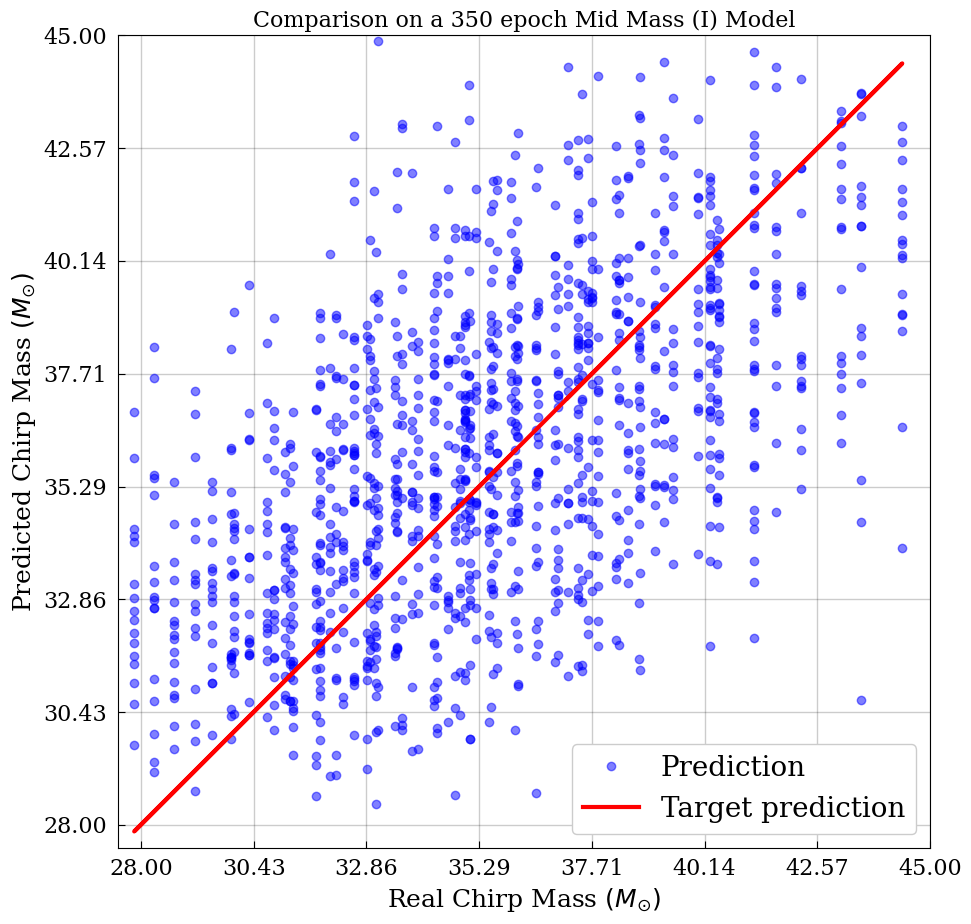

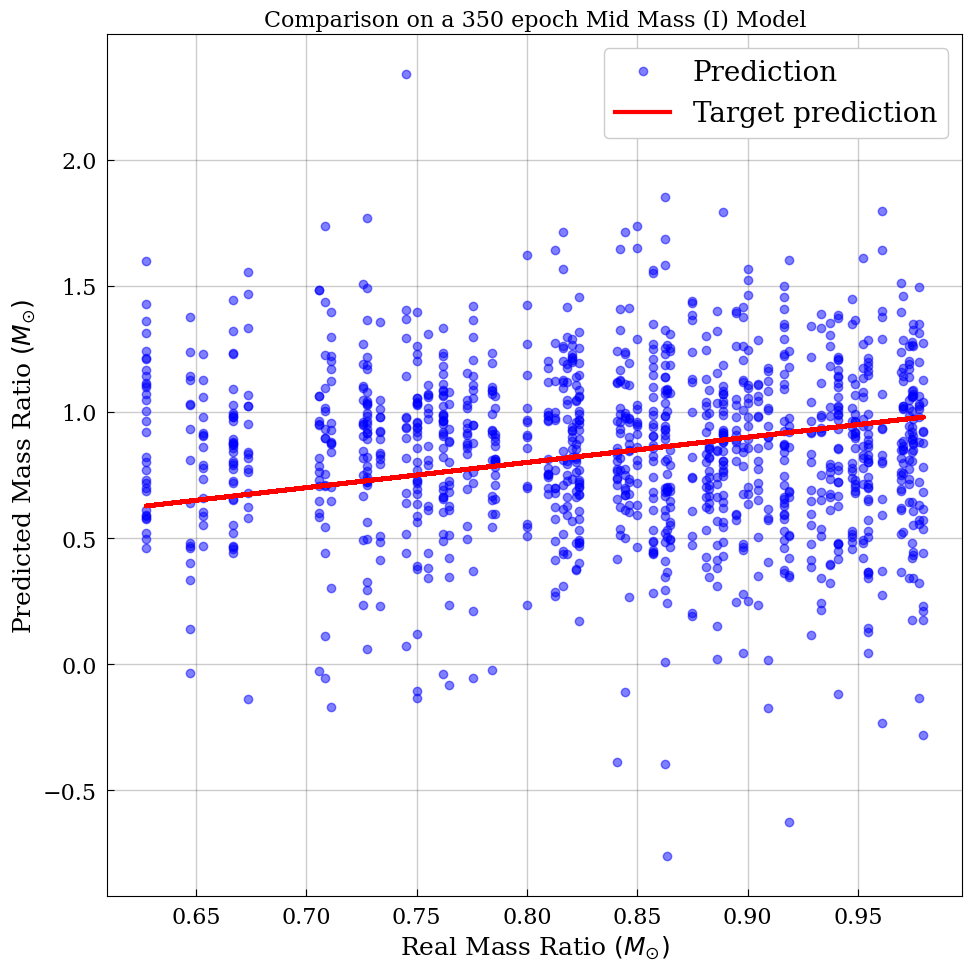

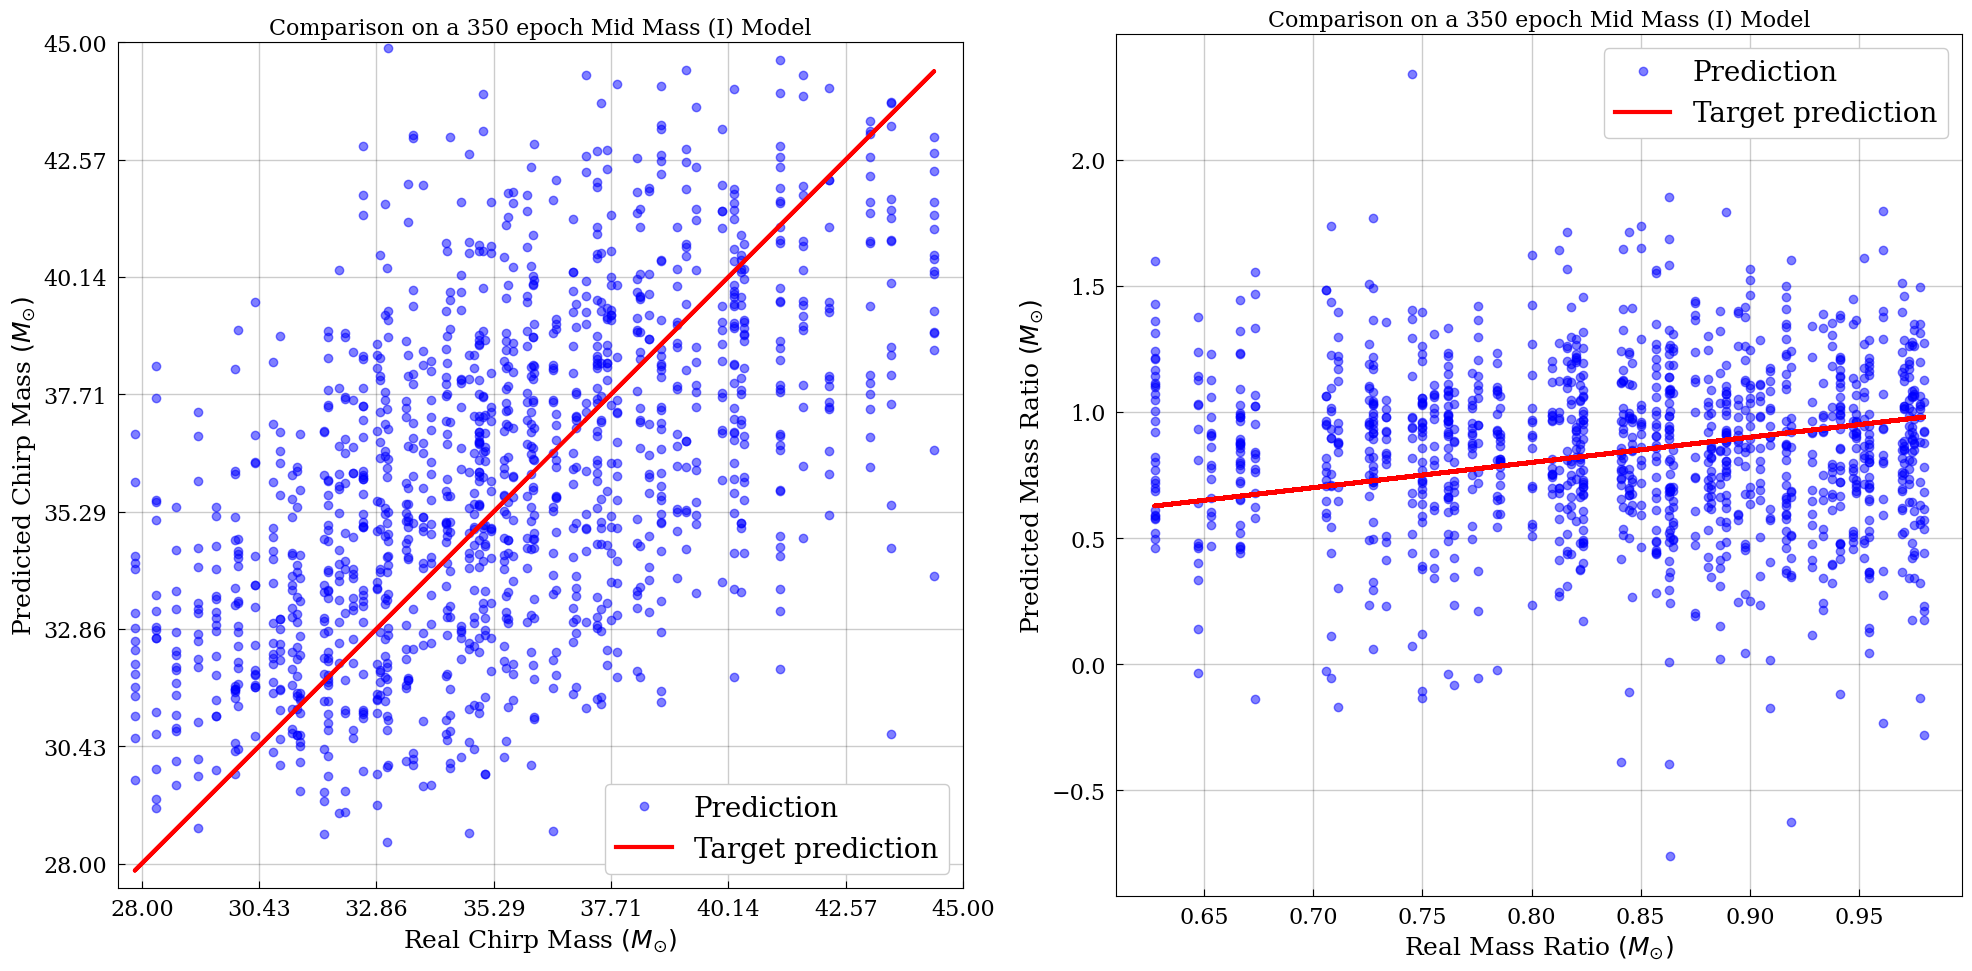

In [38]:
dirs = '/data/danibelt/CNN/2D/Mid_mass_I/Run 10 - 3 ResNet, Last mod/Classifier_epochs350'


model = tf.keras.models.load_model(dirs)

test_Y1_pred, test_Y2_pred = model.predict(test_X_series)


# Test -- Y pred vs Y series CHIRP

figure_features()
fig = plt.figure(figsize=(10,10)) 
plt.plot(test_Y1_series, test_Y1_pred, 'o', color='blue', alpha=0.5, label='Prediction')
plt.plot(test_Y1_series, test_Y1_series, color='red', linewidth=3, alpha=1, label= 'Target prediction')
plt.ylabel('Predicted Chirp Mass '+r'$(M_{\odot})$')
plt.xlabel('Real Chirp Mass '+r'$(M_{\odot})$')
plt.yscale("linear")
plt.title("Comparison on a 350 epoch Mid Mass (I) Model")
plt.grid(linewidth=1, color='black', alpha=0.2)

plt.xlim(27.5,45)
plt.ylim(27.5,45)

plt.legend(prop={'size':20})
plt.xticks(np.linspace(28, 45, 8))
plt.yticks(np.linspace(28, 45, 8))
plt.tight_layout()

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.savefig("Images_Report/Regressor/Mid_mass_I/Chirp_test.png", dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)

# Test -- Y pred vs Y series RATIO

figure_features()
fig = plt.figure(figsize=(10,10)) 
plt.plot(test_Y2_series, test_Y2_pred, 'o', color='blue', alpha=0.5, label='Prediction')
plt.plot(test_Y2_series, test_Y2_series, color='red', linewidth=3, alpha=1, label= 'Target prediction')
plt.ylabel('Predicted Mass Ratio '+r'$(M_{\odot})$')
plt.xlabel('Real Mass Ratio '+r'$(M_{\odot})$')
plt.yscale("linear")
plt.title("Comparison on a 350 epoch Mid Mass (I) Model")
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.legend(prop={'size':20})

#plt.xlim(np.nanmin(test_Y2_pred), np.nanmax(test_Y2_pred))
#plt.ylim(np.nanmin(test_Y2_series), np.nanmax(test_Y2_series))

#plt.xticks(np.linspace(np.nanmin(test_Y2_pred), np.nanmax(test_Y2_pred),5))
#plt.yticks(np.linspace(np.nanmin(test_Y2_series), np.nanmax(test_Y2_series), 5))
plt.tight_layout()

#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')

plt.savefig("Images_Report/Regressor/Mid_mass_I/Ratio_test.png", dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)


## SUBPLOTS

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), tight_layout=True)
ax1.plot(test_Y1_series, test_Y1_pred, 'o', color='blue', alpha=0.5, label='Prediction')
ax1.plot(test_Y1_series, test_Y1_series, color='red', linewidth=3, alpha=1, label= 'Target prediction')

ax1.set_ylabel('Predicted Chirp Mass '+r'$(M_{\odot})$')
ax1.set_xlabel('Real Chirp Mass '+r'$(M_{\odot})$')
ax1.set_yscale("linear")
ax1.set_title("Comparison on a 350 epoch Mid Mass (I) Model")
ax1.grid(linewidth=1, color='black', alpha=0.2)

ax1.set_xlim(27.5, 45)
ax1.set_ylim(27.5, 45)

ax1.legend(prop={'size':20})
ax1.set_xticks(np.linspace(28, 45, 8))
ax1.set_yticks(np.linspace(28, 45, 8))

ax1.set_aspect('equal', adjustable='box')

ax2.plot(test_Y2_series, test_Y2_pred, 'o', color='blue', alpha=0.5, label='Prediction')
ax2.plot(test_Y2_series, test_Y2_series, color='red', linewidth=3, alpha=1, label= 'Target prediction')
ax2.set_ylabel('Predicted Mass Ratio '+r'$(M_{\odot})$')
ax2.set_xlabel('Real Mass Ratio '+r'$(M_{\odot})$')
ax2.set_yscale("linear")
ax2.set_title("Comparison on a 350 epoch Mid Mass (I) Model")
ax2.grid(linewidth=1, color='black', alpha=0.2)
ax2.legend(prop={'size':20})

#ax2.set_xlim(np.nanmin(test_Y2_pred), np.nanmax(test_Y2_pred))
#ax2.set_ylim(np.nanmin(test_Y2_series), np.nanmax(test_Y2_series))

#plt.xticks(np.linspace(-1, 1.5, 5))
#plt.yticks(np.linspace(-1, 1.5, 5))
plt.tight_layout()

#ax2.set_aspect('equal', adjustable='box')

plt.savefig("Images_Report/Regressor/Mid_mass_I/Chirp_Ratio_test.png", dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)

## COMPUTE RELATIVE ERROR


# Plot Relative Error CHIRP
a = np.reshape(test_Y1_pred,(1,len(test_Y1_pred)))
b = np.reshape(test_Y1_series,(1,len(test_Y1_series)))
rel_err_chirp_MID_I = np.squeeze(((a - b) / b) * 100)

# Plot Relative Error RATIO
a = np.reshape(test_Y2_pred,(1,len(test_Y2_pred)))
b = np.reshape(test_Y2_series,(1,len(test_Y2_series)))
rel_err_ratio_MID_I = np.squeeze(((a - b) / b) * 100)


## Grafica Mid mass II - Regresor

In [39]:
# Definimos unas funciones para cargar los datos, procesarlos y prepararlos como input a la CNN:

def load_data(name, purpose):

        """
        # Loads the data for a given path, yielding a type pycbc.timeseries.TimeSeries
        # ----------------------------------------------------------------------------

        # Arguments:
        # name -- name of the file with extention
        # purpose -- to complete path, must contain 'train' or 'test' and 'signal' or 'noise'

        # Return:
        # data -- dictionary with data, time duration, and frecuency sample
        
        """

               
               
        if purpose == 'train':
            aux_path = training_se_signal_dir
            
        elif purpose == 'test':
            aux_path = test_se_signal_dir
            
        data = pycbc.types.timeseries.load_timeseries(aux_path + '/' + name)
      

        return data
    




##############################   REUTURN    #####################################
class GW_data_generator():

    """
    This class will generate an array of temporal series, each row of the array being a GW series, and also will generate its corresponding
    result (0 for noise, 1 fopr signal), and its chirp mass and mass ratio.
    ----------------------------------------------------------------------------------------------------------------------------------------
    """
    
    def __init__(self, record):
        self.record = record
        


    def generate_indexes(self):
        """
        This function will generate a list of numbers shuffled to identify the series
        """
        idx_list = np.random.permutation(len(self.record)) # we shuffle the training samples

        return idx_list

    
    def process_data(self, name, purpose):

        """
        Process an input data given by returning information about it such as duration and sample rate, 
        and whitening data, bandpassing, normalising and returning an array
        -----------------------------------------------------------------------------------------------

        Arguments:
        name -- name of the file with extention
        purpose -- to complete path, must contain 'train' or 'test' and 'signal' or 'noise'

        Return:
        dictionary type with duration, sample rate, and array in numpy type and TimeSeries type

        """
        data = load_data(name, purpose) 
        length = len(data)

        segment_duration = data.get_duration()
        sample_rate = data.get_sample_rate()
        max_filter_duration = segment_duration / 4
        frec_low_cutoff = 30
        frec_high_cutoff = 200


        # whiten the data
        data = data.whiten(segment_duration, max_filter_duration, remove_corrupted=True, low_frequency_cutoff=frec_low_cutoff, return_psd=False)

        # bandpass
        data = data.lowpass_fir(frec_high_cutoff, 8, beta=5.0, remove_corrupted=True) # bandpassing: supress data for frec>300
        data = data.highpass_fir(frec_low_cutoff, 8, beta=5.0, remove_corrupted=True) # bandpassing: supress data for frec<30

        # normalising data to 1
        data = data / max(data)

        # append zeros to beginning and end of the data to keep the input shape unchanged after cropping corrupted segments
        
        length_cr = len(data)
        dif = length-length_cr
        data.prepend_zeros(int(dif / 2)) # append zeros at beginning
        data.append_zeros(int(dif / 2)) # append zeros at end
        

        # return an array
        data = np.squeeze(np.array(data))

        return data

    def generate_series(self, series_idx, purpose, processing):

        """
        Used to generate a batch with series when training/validating/testing our model.
        -------------------------------------------------------------------------------

        Arguments:
        series_idx -- series identification number iloc: if 1050 images, then it takes num in [0,1050]
        is_training = True
        purpose -- neccesary to specify directory path
        batch_size -- len of the batch to b considered

        Returns:
        series array containing the temporal series
        result -- array with corresponding 0 for noise and 1 for signal
        chirp mass -- array containing corresponding chirp mass of signal series
        mass ratio -- array containing corresponding mass ratio of signal series

        Raise:
        ValueError: Batch size must be multiple of 2 to contain same number of noise than signal series in each batch

        """
        


        # arrays to store our batched data
        series = np.empty((1,int(3*2048)),dtype=float)
        chirpM = np.array([])
        qratio = np.array([])
        

        for idx in (series_idx): #tqdm.tqdm

            ######   WE APPEND A SIGNAL SERIES  ########
            parameters = self.record.iloc[idx] # returns the row of data corresponding to such series iloc
            file_name = parameters['Ref.Name']    

            # here we load the data and process it according to signal or noise

            # with processing
            if processing == True:    
                series_np = self.process_data(file_name, purpose)
            # with no processing
            if processing == False:
                series_np = np.array(load_data(file_name, purpose))

            
            chirpM = np.hstack((chirpM, parameters['Chirp mass']))  
            qratio = np.hstack((qratio, parameters['Mass ratio']))    
                   
            series = np.vstack((series, series_np))
        
        series = np.delete(series, 0, axis=0) # delete first row of np.empty

        return series, chirpM, qratio

In [40]:
file_name = 'CNN_Images_Run35_m1_m2_mid_mass_II'

"""
CNN_Images_Run35_m1_m2_low_mass
CNN_Images_Run35_m1_m2_mid_mass_I
CNN_Images_Run35_m1_m2_mid_mass_II
CNN_Images_Run35_m1_m2_high_mass
"""

root_dir = '/data/danibelt/Images_Series_Chirp_Ratio_1/'
#root_dir = '/run/user/1001/gvfs/sftp:host=pcaecuda2,user=danibelt/data/danibelt/Images_Series_Chirp_Ratio_1/'


base_dir = os.path.join(root_dir, file_name)

# training and test path (2)
training_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

# series and images paths, two per previous path (4)
image_tr_dir = os.path.join(training_dir, 'Images')
image_te_dir = os.path.join(test_dir, 'Images')
series_tr_dir = os.path.join(training_dir, 'Series')
series_te_dir = os.path.join(test_dir, 'Series')

# signal and noise paths, two per previous path (8)
training_se_signal_dir = os.path.join(series_tr_dir, 'Signal')
training_se_noise_dir = os.path.join(series_tr_dir, 'Noise')

test_se_signal_dir = os.path.join(series_te_dir, 'Signal')
test_se_noise_dir = os.path.join(series_te_dir, 'Noise')


# We opne .csv file and append extentions .png and .hdf where needed.

# for SERIES
record_path_train = os.path.join(series_tr_dir,'Records_training_signal.csv')
record_train_series = pd.read_csv(record_path_train, sep='\t')

record_path_test = os.path.join(series_te_dir,'Records_test_signal.csv')
record_test_series = pd.read_csv(record_path_test, sep='\t')


def append_ext_png(fn):
    return fn+".png"

def append_ext_hdf(fn):
    return fn+".hdf"

# for SERIES
record_test_series["Ref.Name"]=record_test_series["Ref.Name"].apply(append_ext_hdf)


# test set of series 

data_generator_test = GW_data_generator(record_test_series)
test_idx = data_generator_test.generate_indexes()
test_X_series, test_Y1_series, test_Y2_series = data_generator_test.generate_series(test_idx, purpose='test', processing=True)


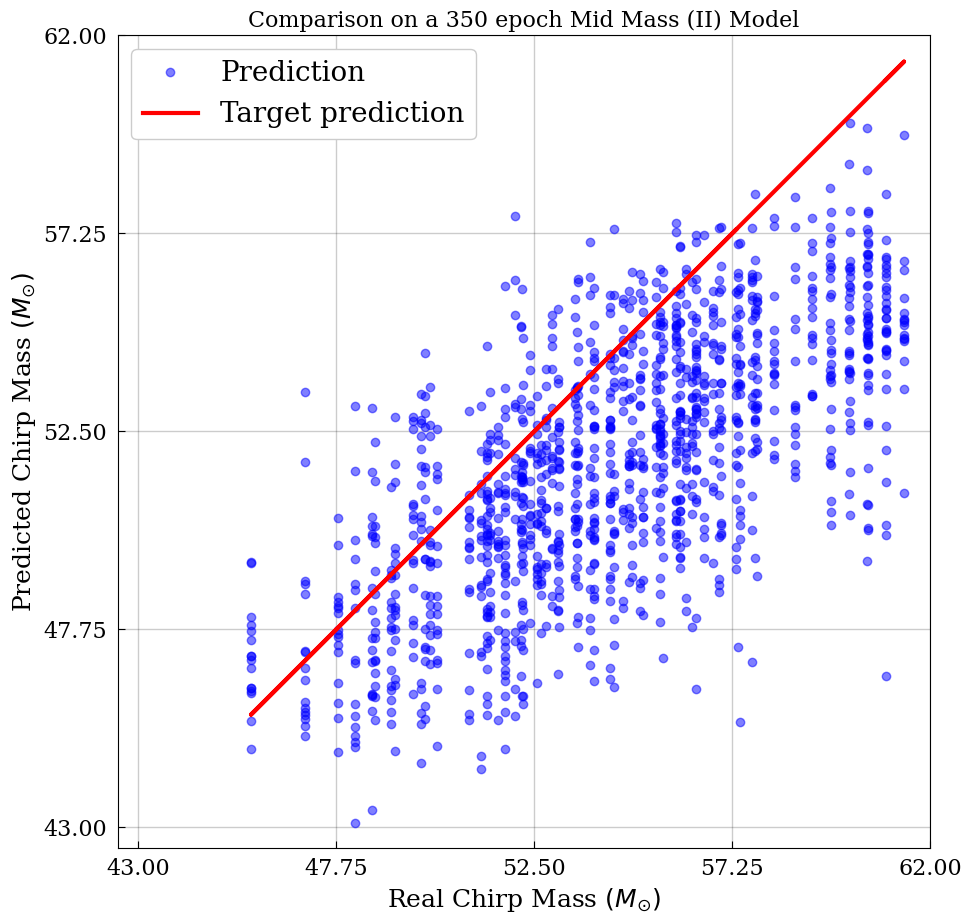

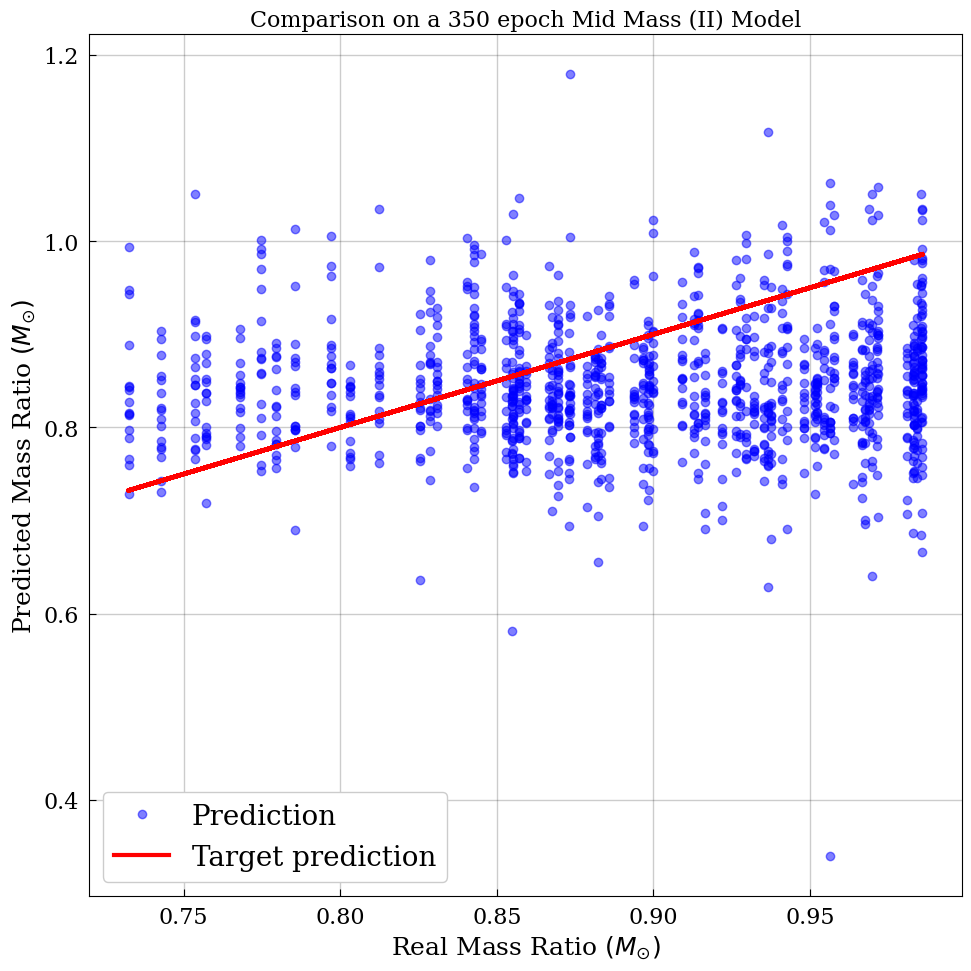

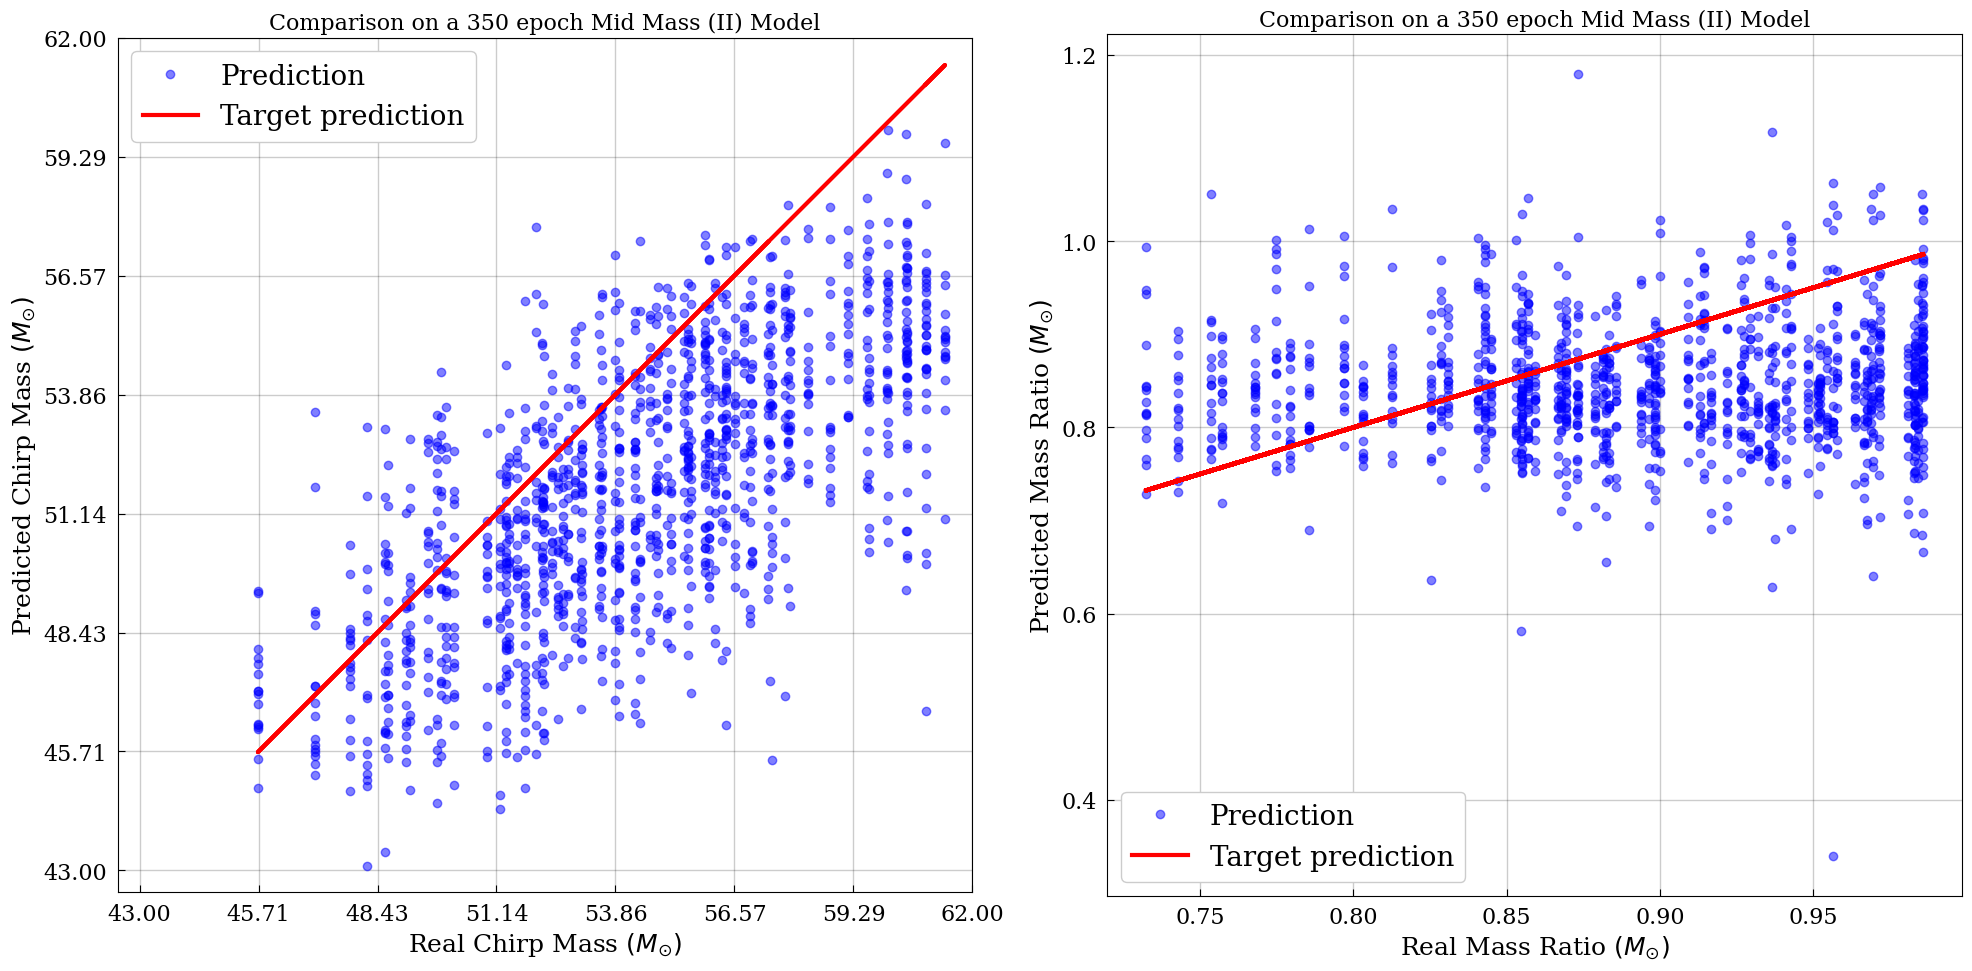

In [41]:
dirs = '/data/danibelt/CNN/2D/Mid_mass_II/Run 10 - 3 ResNet, Last mod/Classifier_epochs350'


model = tf.keras.models.load_model(dirs)

test_Y1_pred, test_Y2_pred = model.predict(test_X_series)


# Test -- Y pred vs Y series CHIRP

figure_features()
fig = plt.figure(figsize=(10,10)) 
plt.plot(test_Y1_series, test_Y1_pred, 'o', color='blue', alpha=0.5, label='Prediction')
plt.plot(test_Y1_series, test_Y1_series, color='red', linewidth=3, alpha=1, label= 'Target prediction')
plt.ylabel('Predicted Chirp Mass '+r'$(M_{\odot})$')
plt.xlabel('Real Chirp Mass '+r'$(M_{\odot})$')
plt.yscale("linear")
plt.title("Comparison on a 350 epoch Mid Mass (II) Model")
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.legend(prop={'size':20})

plt.xlim(42.5, 62)
plt.ylim(42.5, 62)

plt.xticks(np.linspace(43, 62,5))
plt.yticks(np.linspace(43, 62,5))
plt.tight_layout()

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.savefig("Images_Report/Regressor/Mid_mass_II/Chirp_test.png", dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)

# Test -- Y pred vs Y series RATIO

figure_features()
fig = plt.figure(figsize=(10,10)) 
plt.plot(test_Y2_series, test_Y2_pred, 'o', color='blue', alpha=0.5, label='Prediction')
plt.plot(test_Y2_series, test_Y2_series, color='red', linewidth=3, alpha=1, label= 'Target prediction')
plt.ylabel('Predicted Mass Ratio '+r'$(M_{\odot})$')
plt.xlabel('Real Mass Ratio '+r'$(M_{\odot})$')
plt.yscale("linear")
plt.title("Comparison on a 350 epoch Mid Mass (II) Model")
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.legend(loc='lower left', prop={'size':20})

#plt.xlim(0.5, 1.0)
#plt.ylim(0.5, 1.0)

#plt.xticks(np.linspace(0, 1.5, 5))
#plt.yticks(np.linspace(0, 1.5, 5))
plt.tight_layout()

#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')

plt.savefig("Images_Report/Regressor/Mid_mass_II/Ratio_test.png", dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)



## SUBPLOTS

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), tight_layout=True)
ax1.plot(test_Y1_series, test_Y1_pred, 'o', color='blue', alpha=0.5, label='Prediction')
ax1.plot(test_Y1_series, test_Y1_series, color='red', linewidth=3, alpha=1, label= 'Target prediction')

ax1.set_ylabel('Predicted Chirp Mass '+r'$(M_{\odot})$')
ax1.set_xlabel('Real Chirp Mass '+r'$(M_{\odot})$')
ax1.set_yscale("linear")
ax1.set_title("Comparison on a 350 epoch Mid Mass (II) Model")
ax1.grid(linewidth=1, color='black', alpha=0.2)

ax1.set_xlim(42.5, 62)
ax1.set_ylim(42.5, 62)

ax1.legend(prop={'size':20})
ax1.set_xticks(np.linspace(43, 62, 8))
ax1.set_yticks(np.linspace(43, 62, 8))

ax1.set_aspect('equal', adjustable='box')

ax2.plot(test_Y2_series, test_Y2_pred, 'o', color='blue', alpha=0.5, label='Prediction')
ax2.plot(test_Y2_series, test_Y2_series, color='red', linewidth=3, alpha=1, label= 'Target prediction')
ax2.set_ylabel('Predicted Mass Ratio '+r'$(M_{\odot})$')
ax2.set_xlabel('Real Mass Ratio '+r'$(M_{\odot})$')
ax2.set_yscale("linear")
ax2.set_title("Comparison on a 350 epoch Mid Mass (II) Model")
ax2.grid(linewidth=1, color='black', alpha=0.2)
ax2.legend(loc='lower left', prop={'size':20})

#ax2.set_xlim(np.nanmin(test_Y2_pred), np.nanmax(test_Y2_pred))
#ax2.set_ylim(np.nanmin(test_Y2_series), np.nanmax(test_Y2_series))

#plt.xticks(np.linspace(-1, 1.5, 5))
#plt.yticks(np.linspace(-1, 1.5, 5))
plt.tight_layout()

#ax2.set_aspect('equal', adjustable='box')

plt.savefig("Images_Report/Regressor/Mid_mass_II/Chirp_Ratio_test.png", dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)




## COMPUTE RELATIVE ERROR


# Plot Relative Error CHIRP
a = np.reshape(test_Y1_pred,(1,len(test_Y1_pred)))
b = np.reshape(test_Y1_series,(1,len(test_Y1_series)))
rel_err_chirp_MID_II = np.squeeze(((a - b) / b) * 100)

# Plot Relative Error RATIO
a = np.reshape(test_Y2_pred,(1,len(test_Y2_pred)))
b = np.reshape(test_Y2_series,(1,len(test_Y2_series)))
rel_err_ratio_MID_II = np.squeeze(((a - b) / b) * 100)


## Grafica High mass - Regresor

In [42]:
# Definimos unas funciones para cargar los datos, procesarlos y prepararlos como input a la CNN:

def load_data(name, purpose):

        """
        # Loads the data for a given path, yielding a type pycbc.timeseries.TimeSeries
        # ----------------------------------------------------------------------------

        # Arguments:
        # name -- name of the file with extention
        # purpose -- to complete path, must contain 'train' or 'test' and 'signal' or 'noise'

        # Return:
        # data -- dictionary with data, time duration, and frecuency sample
        
        """

               
               
        if purpose == 'train':
            aux_path = training_se_signal_dir
            
        elif purpose == 'test':
            aux_path = test_se_signal_dir
            
        data = pycbc.types.timeseries.load_timeseries(aux_path + '/' + name)
      

        return data
    




##############################   REUTURN    #####################################
class GW_data_generator():

    """
    This class will generate an array of temporal series, each row of the array being a GW series, and also will generate its corresponding
    result (0 for noise, 1 fopr signal), and its chirp mass and mass ratio.
    ----------------------------------------------------------------------------------------------------------------------------------------
    """
    
    def __init__(self, record):
        self.record = record
        


    def generate_indexes(self):
        """
        This function will generate a list of numbers shuffled to identify the series
        """
        idx_list = np.random.permutation(len(self.record)) # we shuffle the training samples

        return idx_list

    
    def process_data(self, name, purpose):

        """
        Process an input data given by returning information about it such as duration and sample rate, 
        and whitening data, bandpassing, normalising and returning an array
        -----------------------------------------------------------------------------------------------

        Arguments:
        name -- name of the file with extention
        purpose -- to complete path, must contain 'train' or 'test' and 'signal' or 'noise'

        Return:
        dictionary type with duration, sample rate, and array in numpy type and TimeSeries type

        """
        data = load_data(name, purpose) 
        length = len(data)

        segment_duration = data.get_duration()
        sample_rate = data.get_sample_rate()
        max_filter_duration = segment_duration / 4
        frec_low_cutoff = 30
        frec_high_cutoff = 200


        # whiten the data
        data = data.whiten(segment_duration, max_filter_duration, remove_corrupted=True, low_frequency_cutoff=frec_low_cutoff, return_psd=False)

        # bandpass
        data = data.lowpass_fir(frec_high_cutoff, 8, beta=5.0, remove_corrupted=True) # bandpassing: supress data for frec>300
        data = data.highpass_fir(frec_low_cutoff, 8, beta=5.0, remove_corrupted=True) # bandpassing: supress data for frec<30

        # normalising data to 1
        data = data / max(data)

        # append zeros to beginning and end of the data to keep the input shape unchanged after cropping corrupted segments
        
        length_cr = len(data)
        dif = length-length_cr
        data.prepend_zeros(int(dif / 2)) # append zeros at beginning
        data.append_zeros(int(dif / 2)) # append zeros at end
        

        # return an array
        data = np.squeeze(np.array(data))

        return data

    def generate_series(self, series_idx, purpose, processing):

        """
        Used to generate a batch with series when training/validating/testing our model.
        -------------------------------------------------------------------------------

        Arguments:
        series_idx -- series identification number iloc: if 1050 images, then it takes num in [0,1050]
        is_training = True
        purpose -- neccesary to specify directory path
        batch_size -- len of the batch to b considered

        Returns:
        series array containing the temporal series
        result -- array with corresponding 0 for noise and 1 for signal
        chirp mass -- array containing corresponding chirp mass of signal series
        mass ratio -- array containing corresponding mass ratio of signal series

        Raise:
        ValueError: Batch size must be multiple of 2 to contain same number of noise than signal series in each batch

        """
        


        # arrays to store our batched data
        series = np.empty((1,int(3*2048)),dtype=float)
        chirpM = np.array([])
        qratio = np.array([])
        

        for idx in (series_idx): #tqdm.tqdm

            ######   WE APPEND A SIGNAL SERIES  ########
            parameters = self.record.iloc[idx] # returns the row of data corresponding to such series iloc
            file_name = parameters['Ref.Name']    

            # here we load the data and process it according to signal or noise

            # with processing
            if processing == True:    
                series_np = self.process_data(file_name, purpose)
            # with no processing
            if processing == False:
                series_np = np.array(load_data(file_name, purpose))

            
            chirpM = np.hstack((chirpM, parameters['Chirp mass']))  
            qratio = np.hstack((qratio, parameters['Mass ratio']))    
                   
            series = np.vstack((series, series_np))
        
        series = np.delete(series, 0, axis=0) # delete first row of np.empty

        return series, chirpM, qratio

In [43]:
file_name = 'CNN_Images_Run35_m1_m2_high_mass'

"""
CNN_Images_Run35_m1_m2_low_mass
CNN_Images_Run35_m1_m2_mid_mass_I
CNN_Images_Run35_m1_m2_mid_mass_II
CNN_Images_Run35_m1_m2_high_mass
"""

root_dir = '/data/danibelt/Images_Series_Chirp_Ratio_1/'
#root_dir = '/run/user/1001/gvfs/sftp:host=pcaecuda2,user=danibelt/data/danibelt/Images_Series_Chirp_Ratio_1/'


base_dir = os.path.join(root_dir, file_name)

# training and test path (2)
training_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

# series and images paths, two per previous path (4)
image_tr_dir = os.path.join(training_dir, 'Images')
image_te_dir = os.path.join(test_dir, 'Images')
series_tr_dir = os.path.join(training_dir, 'Series')
series_te_dir = os.path.join(test_dir, 'Series')

# signal and noise paths, two per previous path (8)
training_se_signal_dir = os.path.join(series_tr_dir, 'Signal')
training_se_noise_dir = os.path.join(series_tr_dir, 'Noise')

test_se_signal_dir = os.path.join(series_te_dir, 'Signal')
test_se_noise_dir = os.path.join(series_te_dir, 'Noise')


# We opne .csv file and append extentions .png and .hdf where needed.

# for SERIES
record_path_train = os.path.join(series_tr_dir,'Records_training_signal.csv')
record_train_series = pd.read_csv(record_path_train, sep='\t')

record_path_test = os.path.join(series_te_dir,'Records_test_signal.csv')
record_test_series = pd.read_csv(record_path_test, sep='\t')


def append_ext_png(fn):
    return fn+".png"

def append_ext_hdf(fn):
    return fn+".hdf"

# for SERIES
record_test_series["Ref.Name"]=record_test_series["Ref.Name"].apply(append_ext_hdf)


# test set of series 

data_generator_test = GW_data_generator(record_test_series)
test_idx = data_generator_test.generate_indexes()
test_X_series, test_Y1_series, test_Y2_series = data_generator_test.generate_series(test_idx, purpose='test', processing=True)


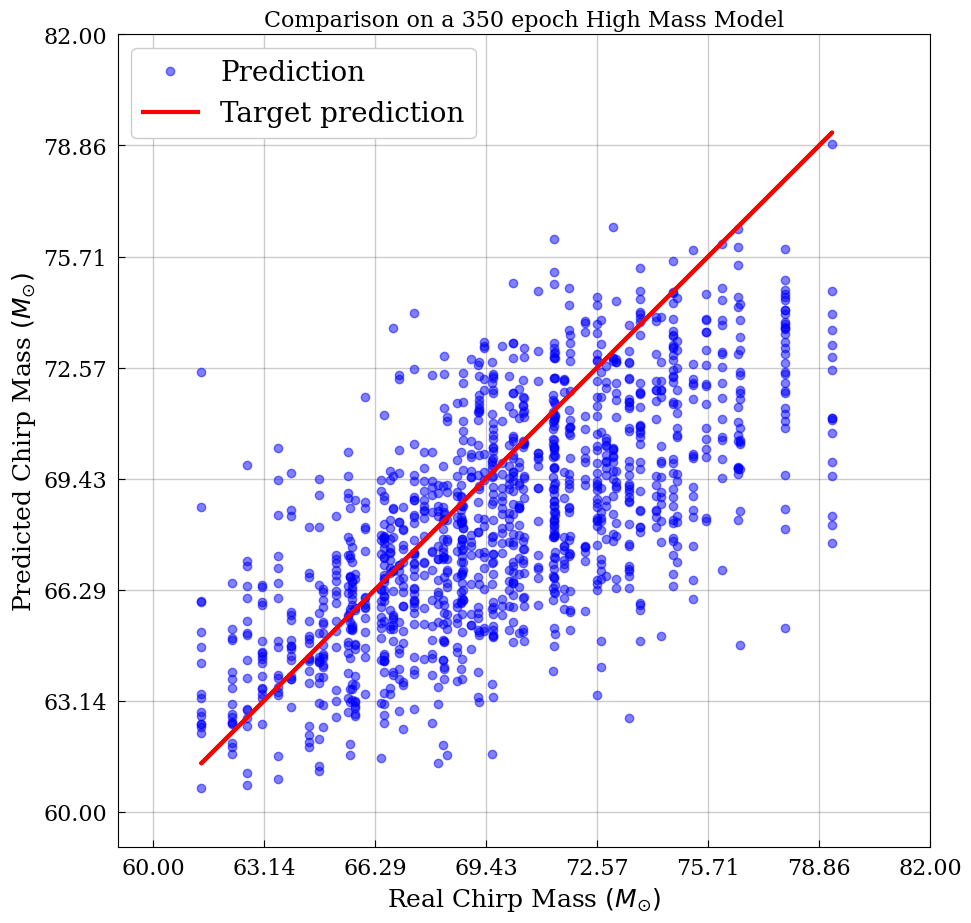

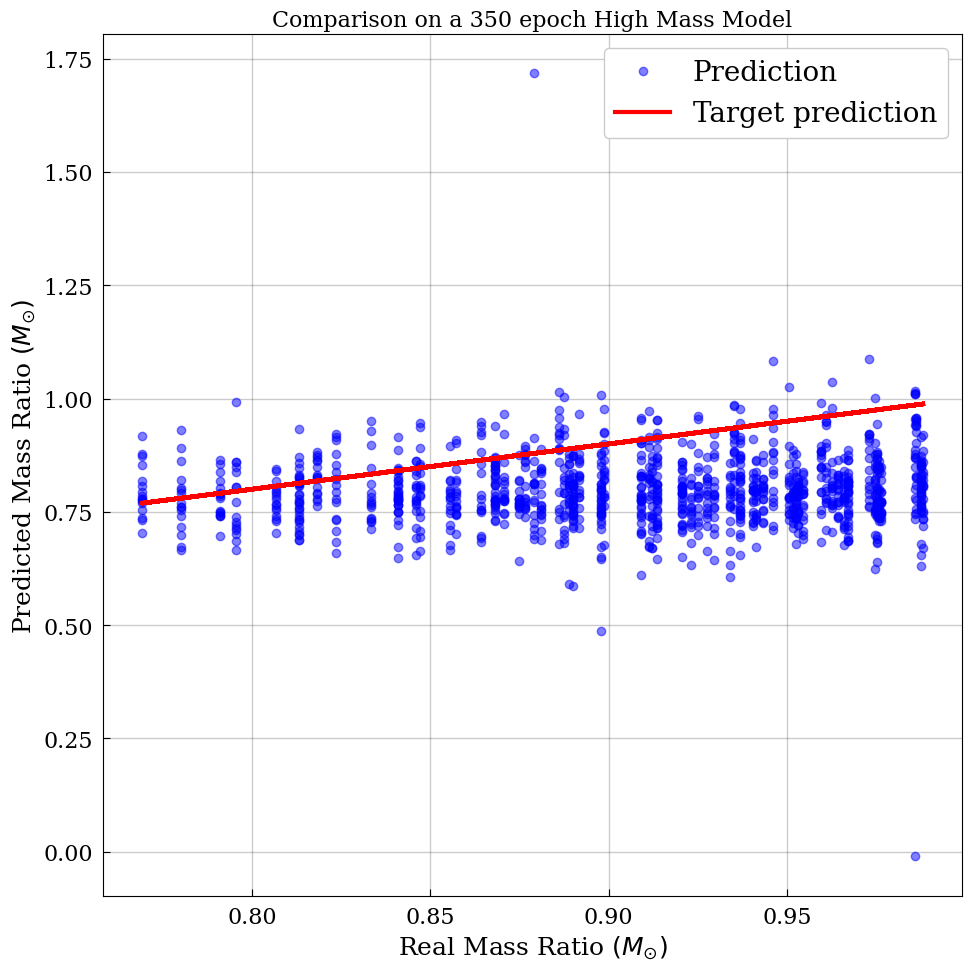

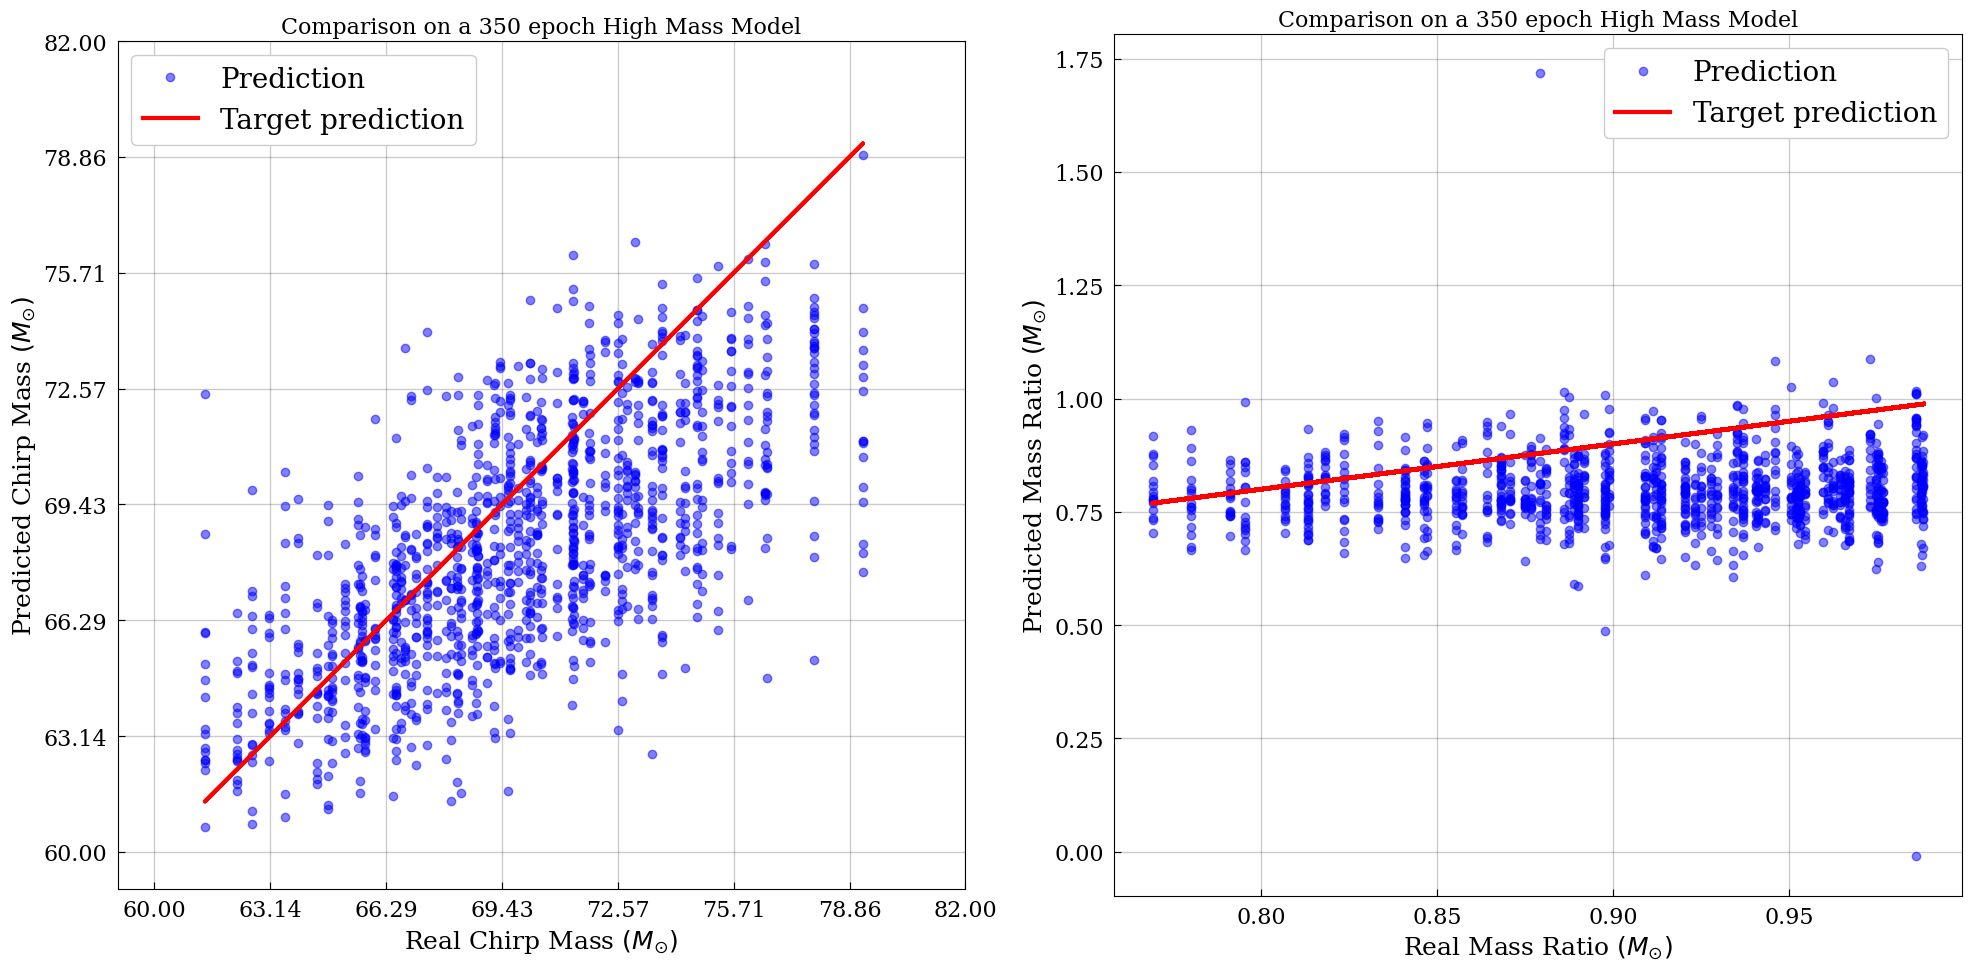

In [44]:
dirs = '/data/danibelt/CNN/2D/High_mass/Run 10 - 3 ResNet, Last mod/Classifier_epochs350'


model = tf.keras.models.load_model(dirs)

test_Y1_pred, test_Y2_pred = model.predict(test_X_series)


# Test -- Y pred vs Y series CHIRP

figure_features()
fig = plt.figure(figsize=(10,10)) 
plt.plot(test_Y1_series, test_Y1_pred, 'o', color='blue', alpha=0.5, label='Prediction')
plt.plot(test_Y1_series, test_Y1_series, color='red', linewidth=3, alpha=1, label= 'Target prediction')
plt.ylabel('Predicted Chirp Mass '+r'$(M_{\odot})$')
plt.xlabel('Real Chirp Mass '+r'$(M_{\odot})$')
plt.yscale("linear")
plt.title("Comparison on a 350 epoch High Mass Model")
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.legend(loc='upper left', prop={'size':20})

plt.xlim(59,82)
plt.ylim(59,82)

plt.xticks(np.linspace(60, 82, 8))
plt.yticks(np.linspace(60, 82, 8))
plt.tight_layout()

ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.savefig("Images_Report/Regressor/High_mass/Chirp_test.png", dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)

# Test -- Y pred vs Y series RATIO

figure_features()
fig = plt.figure(figsize=(10,10)) 
plt.plot(test_Y2_series, test_Y2_pred, 'o', color='blue', alpha=0.5, label='Prediction')
plt.plot(test_Y2_series, test_Y2_series, color='red', linewidth=3, alpha=1, label= 'Target prediction')
plt.ylabel('Predicted Mass Ratio '+r'$(M_{\odot})$')
plt.xlabel('Real Mass Ratio '+r'$(M_{\odot})$')
plt.yscale("linear")
plt.title("Comparison on a 350 epoch High Mass Model")
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.legend(prop={'size':20})

#plt.xlim(-0.1, 1.5)
#plt.ylim(-0.1, 1.5)

#plt.xticks(np.linspace(0, 1.5, 5))
#plt.yticks(np.linspace(0, 1.5, 5))
plt.tight_layout()

#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')

plt.savefig("Images_Report/Regressor/High_mass/Ratio_test.png", dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)




## SUBPLOTS

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), tight_layout=True)
ax1.plot(test_Y1_series, test_Y1_pred, 'o', color='blue', alpha=0.5, label='Prediction')
ax1.plot(test_Y1_series, test_Y1_series, color='red', linewidth=3, alpha=1, label= 'Target prediction')

ax1.set_ylabel('Predicted Chirp Mass '+r'$(M_{\odot})$')
ax1.set_xlabel('Real Chirp Mass '+r'$(M_{\odot})$')
ax1.set_yscale("linear")
ax1.set_title("Comparison on a 350 epoch High Mass Model")
ax1.grid(linewidth=1, color='black', alpha=0.2)

ax1.set_xlim(59, 82)
ax1.set_ylim(59, 82)

ax1.legend(loc='upper left', prop={'size':20})
ax1.set_xticks(np.linspace(60, 82, 8))
ax1.set_yticks(np.linspace(60, 82, 8))

ax1.set_aspect('equal', adjustable='box')

ax2.plot(test_Y2_series, test_Y2_pred, 'o', color='blue', alpha=0.5, label='Prediction')
ax2.plot(test_Y2_series, test_Y2_series, color='red', linewidth=3, alpha=1, label= 'Target prediction')
ax2.set_ylabel('Predicted Mass Ratio '+r'$(M_{\odot})$')
ax2.set_xlabel('Real Mass Ratio '+r'$(M_{\odot})$')
ax2.set_yscale("linear")
ax2.set_title("Comparison on a 350 epoch High Mass Model")
ax2.grid(linewidth=1, color='black', alpha=0.2)
ax2.legend(prop={'size':20})

#ax2.set_xlim(np.nanmin(test_Y2_pred), np.nanmax(test_Y2_pred))
#ax2.set_ylim(np.nanmin(test_Y2_series), np.nanmax(test_Y2_series))

#plt.xticks(np.linspace(-1, 1.5, 5))
#plt.yticks(np.linspace(-1, 1.5, 5))
plt.tight_layout()

#ax2.set_aspect('equal', adjustable='box')

plt.savefig("Images_Report/Regressor/High_mass/Chirp_Ratio_test.png", dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)


## COMPUTE RELATIVE ERROR


# Plot Relative Error CHIRP
a = np.reshape(test_Y1_pred,(1,len(test_Y1_pred)))
b = np.reshape(test_Y1_series,(1,len(test_Y1_series)))
rel_err_chirp_HIGH = np.squeeze(((a - b) / b) * 100)

# Plot Relative Error RATIO
a = np.reshape(test_Y2_pred,(1,len(test_Y2_pred)))
b = np.reshape(test_Y2_series,(1,len(test_Y2_series)))
rel_err_ratio_HIGH = np.squeeze(((a - b) / b) * 100)


## Grafica Errores Relativos - Todos

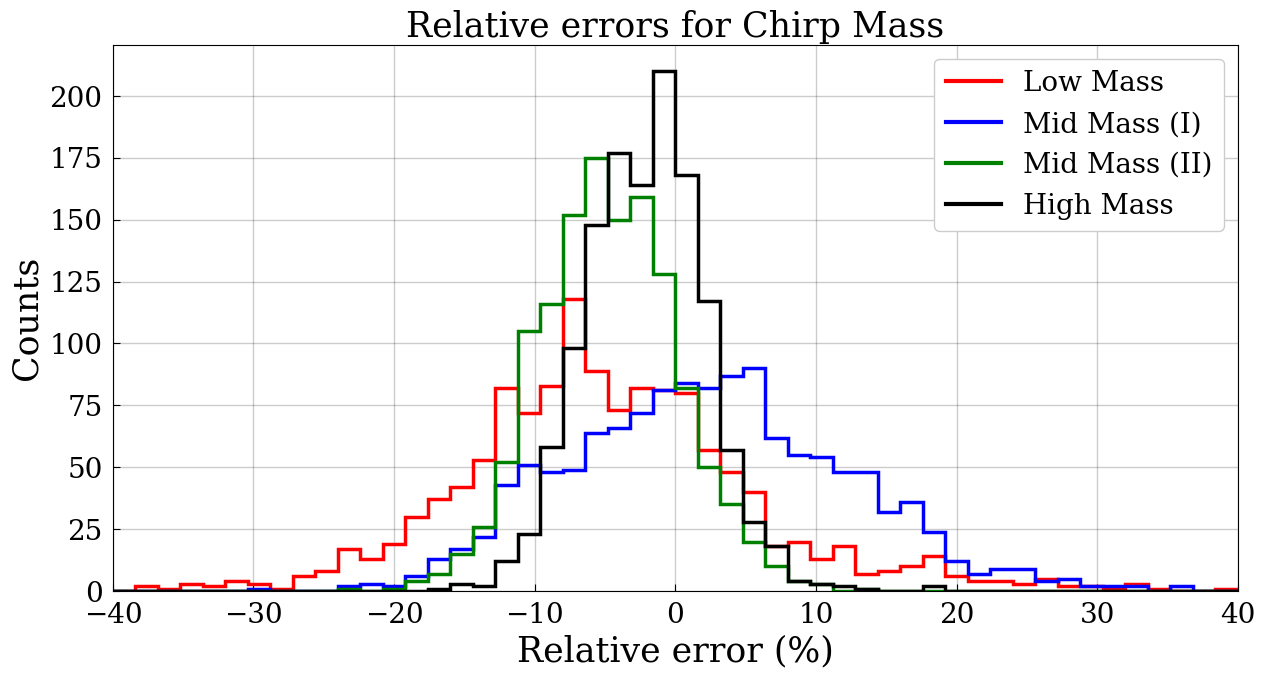

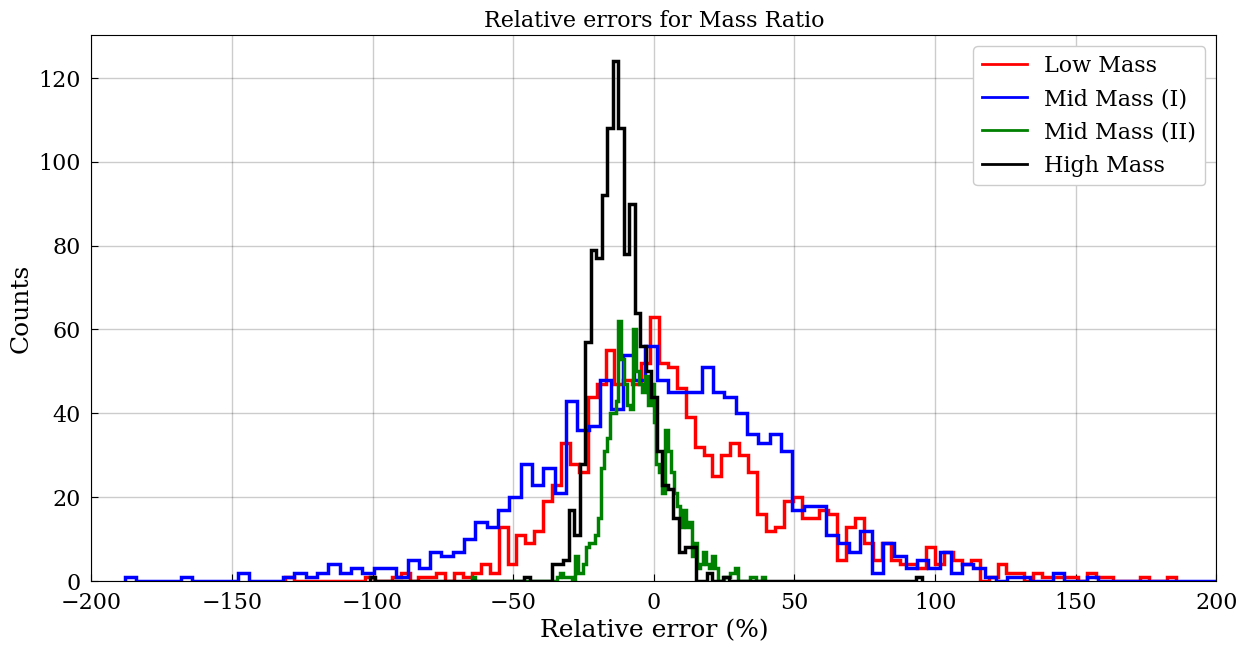

In [47]:
# Chirp

figure_features()
fig = plt.figure(figsize=(15,7)) 
plt.hist(rel_err_chirp_LOW, bins=50, histtype='step', color='red', linewidth=2.5, label='Low Mass', range=(-40,40))
plt.hist(rel_err_chirp_MID_I, bins=50, histtype='step', color='blue', linewidth=2.5, label='Mid Mass (I)', range=(-40,40))
plt.hist(rel_err_chirp_MID_II, bins=50, histtype='step', color='green', linewidth=2.5, label='Mid Mass (II)', range=(-40,40))
plt.hist(rel_err_chirp_HIGH, bins=50, histtype='step', color='black', linewidth=2.5, label='High Mass', range=(-40,40))


labels = ['Low Mass', 'Mid Mass (I)', 'Mid Mass (II)', 'High Mass']
handle1 = matplotlib.lines.Line2D([], [], c='red')
handle2 = matplotlib.lines.Line2D([], [], c='blue')
handle3 = matplotlib.lines.Line2D([], [], c='green')
handle4 = matplotlib.lines.Line2D([], [], c='black')

leg = plt.legend(handles=[handle1, handle2, handle3, handle4],labels=labels, loc='upper right', prop={'size':20})

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.grid(linewidth=1, color='black', alpha=0.2)

plt.xlim(-40,40)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylabel('Counts', fontsize=25)
plt.xlabel('Relative error (%)', fontsize=25)
plt.yscale("linear")
plt.title("Relative errors for Chirp Mass", fontsize=25)
plt.savefig("Images_Report/Regressor/Relative_error_chirp_all.png", dpi=800, pad_inches=0.1, bbox_inches='tight')
plt.show()
plt.close(fig)



# Ratio

figure_features()
fig = plt.figure(figsize=(15,7)) 
plt.hist(rel_err_ratio_LOW, bins=100, histtype='step', color='red', linewidth=2.5, label='Low Mass')
plt.hist(rel_err_ratio_MID_I, bins=100, histtype='step', color='blue', linewidth=2.5, label='Mid Mass (I)')
plt.hist(rel_err_ratio_MID_II, bins=100, histtype='step', color='green', linewidth=2.5, label='Mid Mass (II)')
plt.hist(rel_err_ratio_HIGH, bins=100, histtype='step', color='black', linewidth=2.5, label='High Mass')


labels = ['Low Mass', 'Mid Mass (I)', 'Mid Mass (II)', 'High Mass']
handle1 = matplotlib.lines.Line2D([], [], c='red')
handle2 = matplotlib.lines.Line2D([], [], c='blue')
handle3 = matplotlib.lines.Line2D([], [], c='green')
handle4 = matplotlib.lines.Line2D([], [], c='black')

leg = plt.legend(handles=[handle1, handle2, handle3, handle4],labels=labels, loc='upper right')

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(2.0)

plt.grid(linewidth=1, color='black', alpha=0.2)

plt.xlim(-200,200)

plt.ylabel('Counts')
plt.xlabel('Relative error (%)')
plt.yscale("linear")
plt.title("Relative errors for Mass Ratio")
plt.savefig("Images_Report/Regressor/Relative_error_ratio_all.png")
plt.show()
plt.close(fig)

